# Анализ публикаций с сайта Lenta.ru

В исследовании использованы данные из поста «[Анализируй это — Lenta.ru](https://habr.com/post/343838/)» пользователя [@ildarchegg](https://habr.com/users/ildarchegg/).

[Ссылка на данные](https://drive.google.com/file/d/1NlFuOjOt0oQ9Mx70Z7ZvfOsB3-1fCALp/view)

<a id='0'></a>
+ [Изучение данных](#Изучение данных)
+ [Сбор текстов](#Сбор текстов)
+ [Очистка и нормализация текстов](#Очистка и нормализация текстов)
+ [Обучение тематических моделей по годам](#Обучение тематических моделей по годам)
+ [Топовые темы по годам](#Топовые темы по годам)
+ [Динамика по годам топовых тем за всё время](#Динамика по годам топовых тем за всё время)
  + [Топ-1](#Топ-1)
  + [Топ-5](#Топ-5)
  + [Топ-10](#Топ-10)
+ [Предсказание популярности статьи](#Предсказание популярности статьи)
  + [XGBClassifier](#XGBClassifier)
  + [LogisticRegression](#LogisticRegression)
  + [Embedding & LSTM](#Embedding & LSTM)
+ [Тематика популярных/непопулярных статей](#Тематика популярных/непопулярных статей)
+ [Самые популярные авторы](#Самые популярные авторы)
+ [Путин и Украина в контексте](#Путин и Украина в контексте)

In [1]:
# Библиотеки для работы с данными
import pandas as pd # Работа с данным в формате DataFrame
import numpy as np # Работа с массивами

# Библиотека для работы с MongoDB
from pymongo import MongoClient

# Библиотеки для работы с текстом
import pymorphy2
from nltk.corpus import stopwords
from gensim import corpora, models
import wordcloud

# Библиотеки для визуализации
import matplotlib.pyplot as plt # Для построения графиков
import seaborn as sns # Для более наглядного построения графиков
from matplotlib.colors import LinearSegmentedColormap # Создание собственной цветовой карты
plt.style.use('seaborn-poster') # Настройка стиля визуализации

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

from scipy.stats import pearsonr, chisquare

from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence 
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint


from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Библиотека для работы с предупреждениями
import warnings
warnings.filterwarnings('ignore') # Игнорировать предупреждения

import time
import pickle
%matplotlib inline

Using TensorFlow backend.


<a id='Изучение данных'></a>
## Изучение данных

In [2]:
# Подключение к базе данных с текстами
# sudo service mongod start
# mongoimport --db LentaRu --collection limit_1000  --file file.json --jsonArray
client = MongoClient()
db = client.LentaRu # База
db = db.limit_1000 # Коллекция документов (это полные данные, так назвал, не особо удачно)

In [3]:
# Просмотр структуры документа
db.find_one()

{'_id': ObjectId('5a047652f65ad879056d06de'),
 'link': 'https://lenta.ru/news/2001/01/14/tjumen/',
 'linkDate': '20010114',
 'status': 0,
 'updated_at': '20171109223754 ICT',
 'process': '',
 'page': [{'urlKey': 'httpslentarunews20010114tjumen',
   'url': 'https://lenta.ru/news/2001/01/14/tjumen/',
   'metaTitle': 'В Тюменской области и Ненецком АО губернаторские выборы состоялись',
   'metaType': 'article',
   'metaDescription': '14 января в Тюменской области и Ненецком автономном округе состоялись губернаторские выборы. К 17:00 по московскому времени необходимый 25-процентный барьер явки избирателей был преодолен в обоих регионах. Для победы кандидатам достаточно получить простое большинство голосов.',
   'datetime': '2001-01-14 18:07:54',
   'datetimeString': ' 18:07, 14 января 2001',
   'plaintext': '14 января в Тюменской области и Ненецком автономном округе состоялись губернаторские выборы. В обоих регионах установлен порог явки в 25 процентов, а победитель определяется простым бо

In [4]:
%%time
# Получение ID, даты публикации и перепостов в FB
df = []
df_link = []
df_fb = []
for i in db.find():
    df.append(i['linkDate'])
    df_link.append(i['link'])
    df_fb.append(i['social'][0]['FB'])

CPU times: user 11.7 s, sys: 1.66 s, total: 13.4 s
Wall time: 19.5 s


In [5]:
# Сохранение данных
df = pd.DataFrame({'N': 1,
                   'link': df_link,
                   'FB': df_fb},index=df)
df.index = pd.to_datetime(df.index)

In [8]:
# Сохранение данных
df.to_csv('../data/df_social.csv', index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344000 entries, 2001-01-14 to 2013-12-20
Data columns (total 3 columns):
N       344000 non-null int64
link    344000 non-null object
FB      344000 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.5+ MB


In [6]:
# Индексы статей по годам
indx_1999 = df.link[(df.index >= '1999-01-01')&(df.index < '2000-01-01')].tolist()
indx_2000 = df.link[(df.index >= '2000-01-01')&(df.index < '2001-01-01')].tolist()
indx_2001 = df.link[(df.index >= '2001-01-01')&(df.index < '2002-01-01')].tolist()
indx_2002 = df.link[(df.index >= '2002-01-01')&(df.index < '2003-01-01')].tolist()
indx_2003 = df.link[(df.index >= '2003-01-01')&(df.index < '2004-01-01')].tolist()
indx_2004 = df.link[(df.index >= '2004-01-01')&(df.index < '2005-01-01')].tolist()
indx_2005 = df.link[(df.index >= '2005-01-01')&(df.index < '2006-01-01')].tolist()
indx_2006 = df.link[(df.index >= '2006-01-01')&(df.index < '2007-01-01')].tolist()
indx_2007 = df.link[(df.index >= '2007-01-01')&(df.index < '2008-01-01')].tolist()
indx_2008 = df.link[(df.index >= '2008-01-01')&(df.index < '2009-01-01')].tolist()
indx_2009 = df.link[(df.index >= '2009-01-01')&(df.index < '2010-01-01')].tolist()
indx_2010 = df.link[(df.index >= '2010-01-01')&(df.index < '2011-01-01')].tolist()
indx_2011 = df.link[(df.index >= '2011-01-01')&(df.index < '2012-01-01')].tolist()
indx_2012 = df.link[(df.index >= '2012-01-01')&(df.index < '2013-01-01')].tolist()
indx_2013 = df.link[(df.index >= '2013-01-01')&(df.index < '2014-01-01')].tolist()
indx_2014 = df.link[(df.index >= '2014-01-01')&(df.index < '2015-01-01')].tolist()
indx_2015 = df.link[(df.index >= '2015-01-01')&(df.index < '2016-01-01')].tolist()
indx_2016 = df.link[(df.index >= '2016-01-01')&(df.index < '2017-01-01')].tolist()
indx_2017 = df.link[(df.index >= '2017-01-01')&(df.index < '2018-01-01')].tolist()

In [7]:
# Сумма статей по дням
df_day = df.resample('D').sum()

# Сумма статей по месяцам
df_month = df.resample('M').sum()

# Сумма статей по годам
df_year = df.resample('A-DEC').sum()

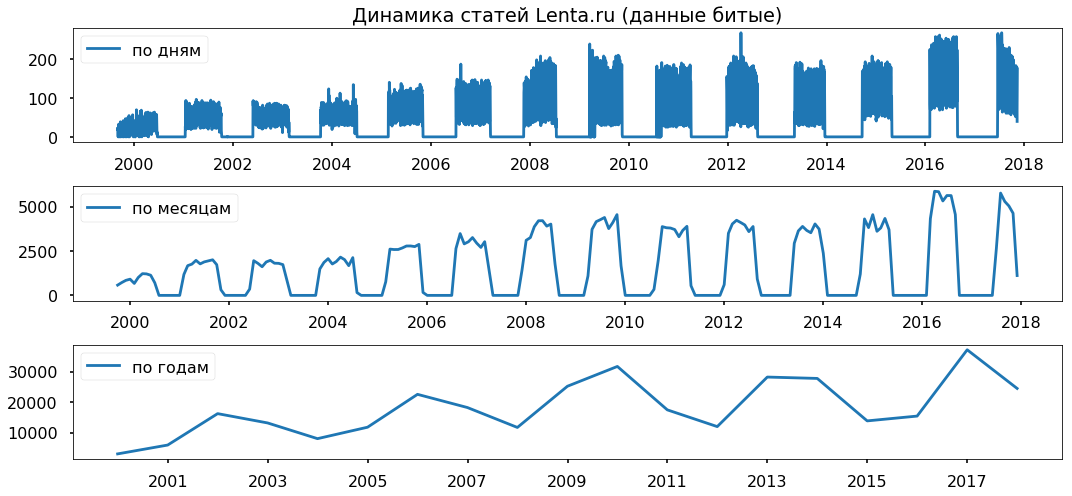

In [8]:
# График "Количество статей на Lenta.ru (данные битые)"
fig = plt.figure(figsize=[15, 7])

plt.subplot(311)
plt.title('Динамика статей Lenta.ru (данные битые)')
plt.plot(df_day.N, '-', label='по дням')
plt.legend()

plt.subplot(312)
plt.plot(df_month.N, '-', label='по месяцам')
plt.legend()

plt.subplot(313)
plt.plot(df_year.N, '-', label='по годам')
plt.legend()

plt.tight_layout()
plt.show()

fig.savefig('../images/Количество статей на Lenta.ru (данные битые).png')

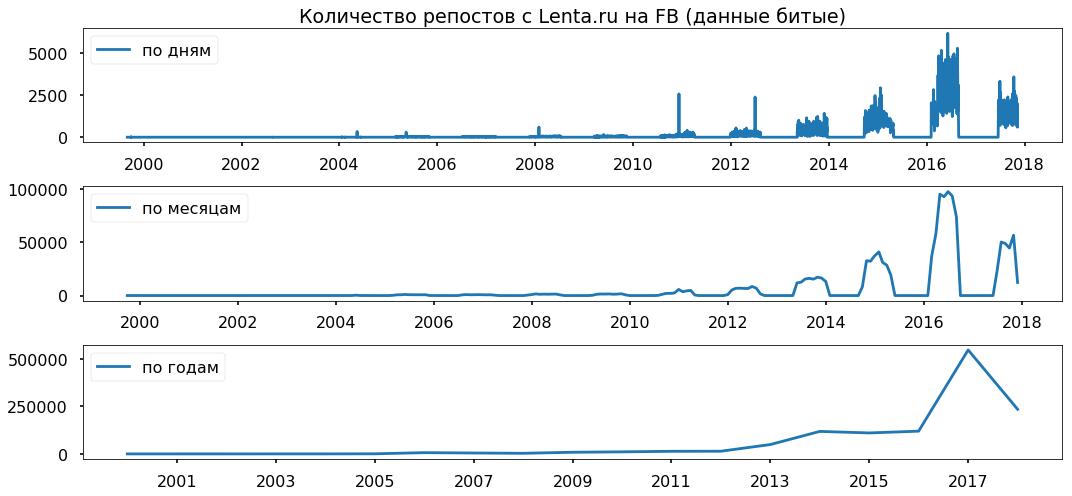

In [15]:
# График "Количество репостов на FB c Lenta.ru (данные битые)"
plt.figure(figsize=[15, 7])

plt.subplot(311)
plt.title('Количество репостов c Lenta.ru на FB (данные битые)')
plt.plot(df_day.FB, '-', label='по дням')
plt.legend()

plt.subplot(312)
plt.plot(df_month.FB, '-', label='по месяцам')
plt.legend()

plt.subplot(313)
plt.plot(df_year.FB, '-', label='по годам')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Количество статей и репостов по годам
df_year

N      FB
1999-12-31   3062      37
2000-12-31   5958       3
2001-12-31  16236       8
2002-12-31  13193      76
2003-12-31   8050      89
2004-12-31  11795     519
2005-12-31  22551    6565
2006-12-31  18229    4741
2007-12-31  11717    3168
2008-12-31  25200    8676
2009-12-31  31676   10822
2010-12-31  17471   13687
2011-12-31  11994   14078
2012-12-31  28204   49335
2013-12-31  27759  118489
2014-12-31  13863  110477
2015-12-31  15436  119778
2016-12-31  37126  547734
2017-12-31  24480  235508

[К содержанию](#0)

<a id='Сбор текстов'></a>
## Сбор текстов

In [33]:
%%time
# Сбор данных за 1999 год
df_text_1999 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_1999}}):
    df_text_1999.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_1999 = pd.DataFrame({'link': indx_1999, 
                             'plaintext': df_text_1999,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_1999.to_csv('../data/df_text_1999.csv', index=False)
del df_text_1999

CPU times: user 148 ms, sys: 8.39 ms, total: 156 ms
Wall time: 365 ms


In [34]:
%%time
# Сбор данных за 2000 год
df_text_2000 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2000}}):
    df_text_2000.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2000 = pd.DataFrame({'link': indx_2000, 
                             'plaintext': df_text_2000,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2000.to_csv('../data/df_text_2000.csv', index=False)
del df_text_2000

CPU times: user 249 ms, sys: 23.6 ms, total: 272 ms
Wall time: 490 ms


In [35]:
%%time
# Сбор данных за 2001 год
df_text_2001 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2001}}):
    df_text_2001.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2001 = pd.DataFrame({'link': indx_2001, 
                             'plaintext': df_text_2001,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2001.to_csv('../data/df_text_2001.csv', index=False)
del df_text_2001

CPU times: user 743 ms, sys: 52.7 ms, total: 796 ms
Wall time: 1.04 s


In [36]:
%%time
# Сбор данных за 2002 год
df_text_2002 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2002}}):
    df_text_2002.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2002 = pd.DataFrame({'link': indx_2002, 
                             'plaintext': df_text_2002,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2002.to_csv('../data/df_text_2002.csv', index=False)
del df_text_2002

CPU times: user 730 ms, sys: 35.6 ms, total: 765 ms
Wall time: 1.01 s


In [37]:
%%time
# Сбор данных за 2003 год
df_text_2003 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2003}}):
    df_text_2003.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2003 = pd.DataFrame({'link': indx_2003, 
                             'plaintext': df_text_2003,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2003.to_csv('../data/df_text_2003.csv', index=False)
del df_text_2003

CPU times: user 475 ms, sys: 52.4 ms, total: 528 ms
Wall time: 756 ms


In [38]:
%%time
# Сбор данных за 2004 год
df_text_2004 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2004}}):
    df_text_2004.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2004 = pd.DataFrame({'link': indx_2004, 
                             'plaintext': df_text_2004,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2004.to_csv('../data/df_text_2004.csv', index=False)
del df_text_2004

CPU times: user 655 ms, sys: 80.4 ms, total: 736 ms
Wall time: 978 ms


In [39]:
%%time
# Сбор данных за 2005 год
df_text_2005 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2005}}):
    df_text_2005.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2005 = pd.DataFrame({'link': indx_2005, 
                             'plaintext': df_text_2005,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2005.to_csv('../data/df_text_2005.csv', index=False)
del df_text_2005

CPU times: user 1.46 s, sys: 103 ms, total: 1.56 s
Wall time: 1.83 s


In [40]:
%%time
# Сбор данных за 2006 год
df_text_2006 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2006}}):
    df_text_2006.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2006 = pd.DataFrame({'link': indx_2006, 
                             'plaintext': df_text_2006,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2006.to_csv('../data/df_text_2006.csv', index=False)
del df_text_2006

CPU times: user 1.03 s, sys: 43 ms, total: 1.08 s
Wall time: 1.34 s


In [41]:
%%time
# Сбор данных за 2007 год
df_text_2007 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2007}}):
    df_text_2007.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2007 = pd.DataFrame({'link': indx_2007, 
                             'plaintext': df_text_2007,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2007.to_csv('../data/df_text_2007.csv', index=False)
del df_text_2007

CPU times: user 600 ms, sys: 51.6 ms, total: 652 ms
Wall time: 898 ms


In [42]:
%%time
# Сбор данных за 2008 год
df_text_2008 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2008}}):
    df_text_2008.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2008 = pd.DataFrame({'link': indx_2008, 
                             'plaintext': df_text_2008,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2008.to_csv('../data/df_text_2008.csv', index=False)
del df_text_2008

CPU times: user 1.4 s, sys: 46.7 ms, total: 1.45 s
Wall time: 1.72 s


In [43]:
%%time
# Сбор данных за 2009 год
df_text_2009 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2009}}):
    df_text_2009.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2009 = pd.DataFrame({'link': indx_2009, 
                             'plaintext': df_text_2009,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2009.to_csv('../data/df_text_2009.csv', index=False)
del df_text_2009

CPU times: user 1.95 s, sys: 101 ms, total: 2.05 s
Wall time: 2.36 s


In [44]:
%%time
# Сбор данных за 2010 год
df_text_2010 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2010}}):
    df_text_2010.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2010 = pd.DataFrame({'link': indx_2010, 
                             'plaintext': df_text_2010,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2010.to_csv('../data/df_text_2010.csv', index=False)
del df_text_2010

CPU times: user 1.07 s, sys: 39.6 ms, total: 1.11 s
Wall time: 1.35 s


In [45]:
%%time
# Сбор данных за 2011 год
df_text_2011 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2011}}):
    df_text_2011.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2011 = pd.DataFrame({'link': indx_2011, 
                             'plaintext': df_text_2011,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2011.to_csv('../data/df_text_2011.csv', index=False)
del df_text_2011

CPU times: user 699 ms, sys: 19.2 ms, total: 718 ms
Wall time: 991 ms


In [46]:
%%time
# Сбор данных за 2012 год
df_text_2012 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2012}}):
    df_text_2012.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2012 = pd.DataFrame({'link': indx_2012, 
                             'plaintext': df_text_2012,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2012.to_csv('../data/df_text_2012.csv', index=False)
del df_text_2012

CPU times: user 1.83 s, sys: 87.5 ms, total: 1.91 s
Wall time: 2.2 s


In [47]:
%%time
# Сбор данных за 2013 год
df_text_2013 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2013}}):
    df_text_2013.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2013 = pd.DataFrame({'link': indx_2013, 
                             'plaintext': df_text_2013,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2013.to_csv('../data/df_text_2013.csv', index=False)
del df_text_2013

CPU times: user 1.84 s, sys: 108 ms, total: 1.95 s
Wall time: 2.24 s


In [48]:
%%time
# Сбор данных за 2014 год
df_text_2014 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2014}}):
    df_text_2014.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2014 = pd.DataFrame({'link': indx_2014, 
                             'plaintext': df_text_2014,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2014.to_csv('../data/df_text_2014.csv', index=False)
del df_text_2014

CPU times: user 908 ms, sys: 63.9 ms, total: 972 ms
Wall time: 1.21 s


In [49]:
%%time
# Сбор данных за 2015 год
df_text_2015 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2015}}):
    df_text_2015.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2015 = pd.DataFrame({'link': indx_2015, 
                             'plaintext': df_text_2015,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2015.to_csv('../data/df_text_2015.csv', index=False)
del df_text_2015

CPU times: user 1.22 s, sys: 63.9 ms, total: 1.28 s
Wall time: 1.54 s


In [50]:
%%time
# Сбор данных за 2016 год
df_text_2016 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2016}}):
    df_text_2016.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2016 = pd.DataFrame({'link': indx_2016, 
                             'plaintext': df_text_2016,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2016.to_csv('../data/df_text_2016.csv', index=False)
del df_text_2016

CPU times: user 2.62 s, sys: 137 ms, total: 2.76 s
Wall time: 3.09 s


In [51]:
%%time
# Сбор данных за 2017 год
df_text_2017 = []
df_fb = []
df_rubric = []
df_subrubric = []
authors = []
for i in db.find({'link': {'$in': indx_2017}}):
    df_text_2017.append(i['page'][0]['plaintext'])
    df_fb.append(i['social'][0]['FB'])
    try:
        df_rubric.append(i['page'][0]['rubric'])
    except:
        df_rubric.append('Нет рубрики')
    try:
        df_subrubric.append(i['page'][0]['subrubric'])
    except:
        df_subrubric.append('Нет субрубрики')
    try:
        authors.append(i['page'][0]['authors'])
    except:
        authors.append('Нет автора')
df_text_2017 = pd.DataFrame({'link': indx_2017, 
                             'plaintext': df_text_2017,
                             'df_fb': df_fb, 
                             'df_rubric': df_rubric,
                             'df_subrubric': df_subrubric,
                             'authors': authors})
df_text_2017.to_csv('../data/df_text_2017.csv', index=False)
del df_text_2017

CPU times: user 4.66 s, sys: 183 ms, total: 4.84 s
Wall time: 5.22 s


[К содержанию](#0)

<a id='Очистка и нормализация текстов'></a>
## Очистка и нормализация текстов

In [52]:
%%time
# Очистка и нормализация текста (тут мне захотелось протестировать globals(), но лучше так не делать)
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv')
    
    # Очистка текста 
    globals()['df_text_%s' % i]['cleantext'] = globals()['df_text_%s' % i].plaintext.str.lower()
    globals()['df_text_%s' % i]['cleantext'] = globals()['df_text_%s' % i].cleantext.str.replace('[\t\n\r\f\v.*$]', '')
    globals()['df_text_%s' % i]['cleantext'] = globals()['df_text_%s' % i].cleantext.str.replace('-', ' ')
    globals()['df_text_%s' % i]['cleantext'] = globals()['df_text_%s' % i].cleantext.str.replace('[^йцукенгшщзхъфывапролджэячсмитьбюё0-9A-Za-z ]+', '')

    # Нормализация текста
    morph = pymorphy2.MorphAnalyzer()
    def text_normalization(input_text):
        return ' '.join([morph.parse(item)[0].normal_form for item in str(input_text).split(' ')])
    globals()['df_text_%s' % i].cleantext = globals()['df_text_%s' % i].cleantext.apply(text_normalization, 1)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    def remove_stops(input_text):
        return ' '.join([w for w in input_text.split() if not w in stop_words])
    globals()['df_text_%s' % i].cleantext = globals()['df_text_%s' % i].cleantext.apply(remove_stops, 1)
    globals()['df_text_%s' % i].to_csv('../data/df_text_'+str(i)+'.csv', index=False)
    del globals()['df_text_%s' % i]
    print(i)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
CPU times: user 3h 45min 44s, sys: 4.12 s, total: 3h 45min 48s
Wall time: 3h 45min 49s


[К содержанию](#0)

<a id='Обучение тематических моделей по годам'></a>
## Обучение тематических моделей по годам

In [2]:
%%time
# Обучение моделей
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv') 
    
    # Создание корпуса
    documents = [[word for word in str(document).split()] for document in globals()['df_text_%s' % i].cleantext.tolist()]
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(text) for text in documents]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    globals()['lda_%s' % i] = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                                       num_topics=1,
                                                       passes=30, alpha=1.25, eta=1.25)
    print(i)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
CPU times: user 2h 4min 21s, sys: 35.2 s, total: 2h 4min 56s
Wall time: 1h 35min 13s


[К содержанию](#0)

<a id='Топовые темы по годам'></a>
## Топовые темы по годам

In [3]:
# Сохранение моделей
for i in range(1999, 2018, 1):
    globals()['lda_%s' % i].save('../models/lda_'+str(i))

In [5]:
lda_1999.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"россия" + 0.001*"российский" + 0.001*"год" + 0.001*"чечня" + 0.001*"президент" + 0.001*"москва" + 0.001*"суд" + 0.000*"человек" + 0.000*"декабрь" + 0.000*"федеральный"')]

In [6]:
lda_2000.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"чечня" + 0.001*"россия" + 0.001*"год" + 0.001*"президент" + 0.001*"боевик" + 0.001*"российский" + 0.001*"человек" + 0.001*"который" + 0.001*"это" + 0.001*"район"')]

In [24]:
lda_2001.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"сша" + 0.001*"год" + 0.001*"россия" + 0.001*"человек" + 0.001*"это" + 0.001*"который" + 0.001*"свой" + 0.001*"самолёт" + 0.001*"весь" + 0.001*"президент" + 0.001*"процент" + 0.001*"суд" + 0.001*"компания" + 0.001*"время" + 0.001*"российский" + 0.001*"доллар" + 0.001*"заявить" + 0.001*"москва" + 0.001*"израильский" + 0.001*"министр"')]

In [8]:
lda_2002.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"россия" + 0.001*"год" + 0.001*"сша" + 0.001*"человек" + 0.001*"президент" + 0.001*"ирак" + 0.001*"российский" + 0.001*"москва" + 0.001*"военный" + 0.001*"страна"')]

In [9]:
lda_2003.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"ирак" + 0.001*"год" + 0.001*"сша" + 0.001*"человек" + 0.001*"президент" + 0.001*"процент" + 0.001*"россия" + 0.001*"страна" + 0.001*"суд" + 0.001*"москва"')]

In [10]:
lda_2004.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"ирак" + 0.001*"год" + 0.001*"россия" + 0.001*"президент" + 0.001*"сша" + 0.001*"аль" + 0.001*"американский" + 0.001*"человек" + 0.001*"страна" + 0.001*"матч"')]

In [25]:
lda_2005.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"россия" + 0.001*"год" + 0.001*"процент" + 0.001*"президент" + 0.001*"компания" + 0.001*"человек" + 0.001*"российский" + 0.001*"сша" + 0.001*"страна" + 0.001*"доллар" + 0.001*"суд" + 0.001*"это" + 0.001*"министр" + 0.001*"свой" + 0.001*"весь" + 0.001*"дело" + 0.001*"украина" + 0.001*"военный" + 0.001*"время" + 0.001*"заявить"')]

In [26]:
lda_2006.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"год" + 0.001*"россия" + 0.001*"компания" + 0.001*"президент" + 0.001*"процент" + 0.001*"доллар" + 0.001*"декабрь" + 0.001*"российский" + 0.001*"страна" + 0.001*"человек" + 0.001*"это" + 0.001*"свой" + 0.001*"который" + 0.001*"2006" + 0.001*"весь" + 0.001*"сша" + 0.001*"время" + 0.001*"заявить" + 0.001*"суд" + 0.001*"дело"')]

In [27]:
lda_2007.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"россия" + 0.001*"процент" + 0.001*"компания" + 0.001*"год" + 0.001*"президент" + 0.001*"доллар" + 0.001*"человек" + 0.001*"это" + 0.001*"страна" + 0.001*"свой" + 0.001*"который" + 0.001*"российский" + 0.001*"суд" + 0.001*"партия" + 0.001*"сша" + 0.001*"весь" + 0.000*"время" + 0.000*"дело" + 0.000*"заявить" + 0.000*"миллион"')]

In [28]:
lda_2008.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"процент" + 0.001*"компания" + 0.001*"год" + 0.001*"доллар" + 0.001*"россия" + 0.001*"человек" + 0.001*"президент" + 0.001*"сша" + 0.001*"страна" + 0.001*"это" + 0.001*"миллион" + 0.001*"свой" + 0.001*"российский" + 0.001*"который" + 0.001*"июнь" + 0.001*"агентство" + 0.001*"время" + 0.001*"тысяча" + 0.001*"2008" + 0.001*"суд"')]

In [29]:
lda_2009.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"процент" + 0.001*"россия" + 0.001*"доллар" + 0.001*"октябрь" + 0.001*"год" + 0.001*"компания" + 0.001*"рубль" + 0.001*"человек" + 0.001*"президент" + 0.001*"миллиард" + 0.001*"миллион" + 0.001*"российский" + 0.001*"сентябрь" + 0.001*"украина" + 0.001*"страна" + 0.001*"2009" + 0.001*"свой" + 0.001*"суд" + 0.001*"матч" + 0.001*"весь"')]

In [30]:
lda_2010.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"декабрь" + 0.001*"россия" + 0.001*"год" + 0.001*"процент" + 0.001*"человек" + 0.001*"компания" + 0.001*"москва" + 0.001*"доллар" + 0.001*"президент" + 0.001*"дело" + 0.001*"ноябрь" + 0.001*"российский" + 0.001*"миллион" + 0.001*"матч" + 0.001*"свой" + 0.001*"рубль" + 0.001*"весь" + 0.001*"страна" + 0.001*"акция" + 0.001*"миллиард"')]

In [31]:
lda_2011.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"процент" + 0.001*"март" + 0.001*"россия" + 0.001*"ливия" + 0.001*"человек" + 0.001*"компания" + 0.001*"страна" + 0.001*"год" + 0.001*"президент" + 0.001*"доллар" + 0.001*"матч" + 0.001*"февраль" + 0.001*"свой" + 0.001*"миллион" + 0.001*"сша" + 0.000*"акция" + 0.000*"весь" + 0.000*"каддафи" + 0.000*"миллиард" + 0.000*"москва"')]

In [32]:
lda_2012.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"процент" + 0.001*"россия" + 0.001*"компания" + 0.001*"июль" + 0.001*"человек" + 0.001*"год" + 0.001*"август" + 0.001*"дело" + 0.001*"рубль" + 0.001*"миллион" + 0.001*"доллар" + 0.001*"президент" + 0.001*"страна" + 0.001*"суд" + 0.001*"весь" + 0.001*"полиция" + 0.001*"свой" + 0.001*"тысяча" + 0.001*"июнь" + 0.001*"акция"')]

In [33]:
lda_2013.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"ноябрь" + 0.001*"россия" + 0.001*"человек" + 0.001*"компания" + 0.001*"процент" + 0.001*"декабрь" + 0.001*"год" + 0.001*"рубль" + 0.001*"страна" + 0.001*"дело" + 0.001*"доллар" + 0.001*"президент" + 0.000*"свой" + 0.000*"российский" + 0.000*"весь" + 0.000*"игра" + 0.000*"миллион" + 0.000*"сша" + 0.000*"власть" + 0.000*"полиция"')]

### Годы Украины в России (топовые темы Lenta.ru с 2014 по 2017 гг.)

#### 2014 г.

In [20]:
lda_2014.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"украина" + 0.001*"рубль" + 0.001*"россия" + 0.001*"год" + 0.001*"процент" + 0.001*"президент" + 0.001*"декабрь" + 0.001*"компания" + 0.001*"российский" + 0.001*"доллар"')]

#### 2015 г.

In [21]:
lda_2015.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"украина" + 0.001*"россия" + 0.001*"рубль" + 0.001*"процент" + 0.001*"апрель" + 0.001*"президент" + 0.001*"год" + 0.001*"человек" + 0.001*"страна" + 0.001*"российский"')]

#### 2016 г.

In [37]:
lda_2016.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"август" + 0.001*"июль" + 0.001*"россия" + 0.001*"украина" + 0.001*"процент" + 0.001*"российский" + 0.001*"человек" + 0.001*"игра" + 0.001*"страна" + 0.001*"год"')]

#### 2017 г.

In [36]:
lda_2017.print_topics(num_topics=1, num_words=10)

[(0,
  '0.001*"россия" + 0.001*"октябрь" + 0.001*"год" + 0.001*"украина" + 0.001*"человек" + 0.001*"сша" + 0.001*"процент" + 0.001*"весь" + 0.001*"ноябрь" + 0.001*"президент"')]

[К содержанию](#0)

<a id='Динамика по годам топовых тем за всё время'></a>
## Динамика по годам топовых тем за всё время 

In [9]:
# Создание цветовой карты
colors = ["#000000", "#111111", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

In [10]:
words = str()
for i in range(1999, 2018, 1):
    # Загрузка данных
    df = pd.read_csv('../data/df_text_'+str(i)+'.csv')
    df.cleantext = df.cleantext.astype('str')
    words_temp = ' '.join(df.cleantext)
    words += words_temp

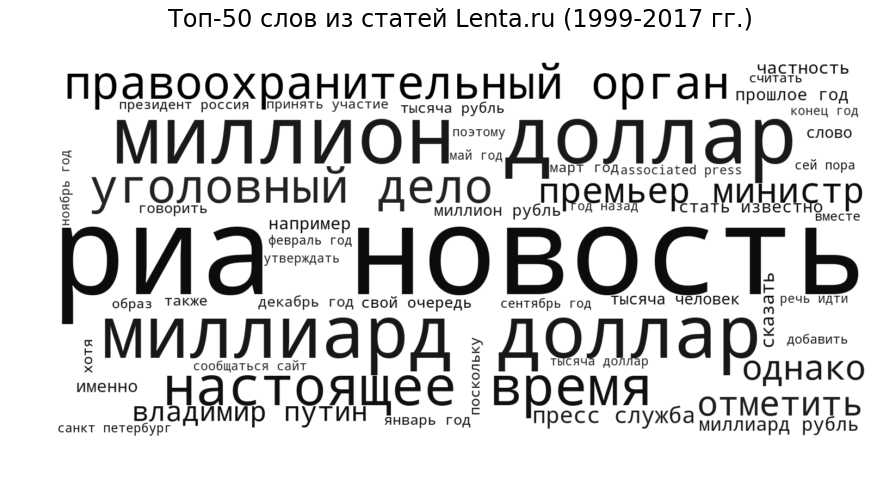

CPU times: user 3min 35s, sys: 6.41 s, total: 3min 42s
Wall time: 3min 41s


In [11]:
%%time
# Облако тэгов
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=400,
                            width=1500,
                            height=700,
                            max_words=50,
                            relative_scaling=1,
                            stopwords = ['это  сообщать', 'кроме', 
                                         'это', 'сообщать']
                            ).generate(words)
fig = plt.figure(figsize=(15,7))
plt.title('Топ-50 слов из статей Lenta.ru (1999-2017 гг.)\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()
fig.savefig('../images/Облако тегов.png')

<a id='Топ-1'></a>
### Топ-1

In [9]:
%%time
# Обучение моделей
documents = []
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv') 
    
    # Создание корпуса
    documents_temp = [[word for word in str(document).split()] for document in globals()['df_text_%s' % i].cleantext.tolist()]
    documents.extend(documents_temp)
    
    del globals()['df_text_%s' % i]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_all_1 = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                     num_topics=1,
                                     passes=30, alpha=1.25, eta=1.25)

CPU times: user 2h 42min 30s, sys: 1min 7s, total: 2h 43min 37s
Wall time: 1h 35min 19s


In [10]:
# Сохранение моделей
lda_all_1.save('../models/lda_all_1')

In [11]:
lda_all_1.print_topics(num_topics=1, num_words=20)

[(0,
  '0.001*"россия" + 0.001*"украина" + 0.001*"июль" + 0.001*"август" + 0.001*"год" + 0.001*"российский" + 0.001*"2016" + 0.001*"человек" + 0.001*"это" + 0.001*"процент" + 0.001*"рубль" + 0.001*"президент" + 0.001*"страна" + 0.001*"сентябрь" + 0.001*"2017" + 0.001*"весь" + 0.001*"мужчина" + 0.001*"тысяча" + 0.001*"сша" + 0.001*"июнь"')]

[К содержанию](#0)

<a id='Топ-5'></a>
### Топ-5

In [46]:
%%time
# Обучение моделей
documents = []
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv') 
    
    # Создание корпуса
    documents_temp = [[word for word in str(document).split()] for document in globals()['df_text_%s' % i].cleantext.tolist()]
    documents.extend(documents_temp)
    
    del globals()['df_text_%s' % i]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_all_5 = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                     num_topics=5,
                                     passes=30, alpha=1.25, eta=1.25)

CPU times: user 6h 19min 11s, sys: 4min 2s, total: 6h 23min 14s
Wall time: 2h 19min 21s


In [4]:
# Сохранение моделей
lda_all_5.save('../models/lda_all_5')

In [3]:
# Загрузка модели
lda_all_5 = models.ldamodel.LdaModel.load('../models/lda_all_5')

In [4]:
lda_all_5.print_topics(num_topics=5, num_words=20)

[(0,
  '0.002*"мужчина" + 0.002*"полиция" + 0.002*"произойти" + 0.002*"женщина" + 0.001*"автомобиль" + 0.001*"задержать" + 0.001*"город" + 0.001*"человек" + 0.001*"дом" + 0.001*"летний" + 0.001*"ребёнок" + 0.001*"полицейский" + 0.001*"район" + 0.001*"машина" + 0.001*"сотрудник" + 0.001*"инцидент" + 0.001*"погибнуть" + 0.001*"находиться" + 0.001*"обнаружить" + 0.001*"следственный"'),
 (1,
  '0.002*"россия" + 0.002*"украина" + 0.001*"год" + 0.001*"российский" + 0.001*"июль" + 0.001*"это" + 0.001*"процент" + 0.001*"рубль" + 0.001*"президент" + 0.001*"2016" + 0.001*"страна" + 0.001*"август" + 0.001*"сентябрь" + 0.001*"2017" + 0.001*"весь" + 0.001*"тысяча" + 0.001*"сша" + 0.001*"глава" + 0.001*"заявить" + 0.001*"компания"'),
 (2,
  '0.000*"пэддок" + 0.000*"фельгенгауэр" + 0.000*"малороссия" + 0.000*"ирма" + 0.000*"грица" + 0.000*"сямозеро" + 0.000*"гюлена" + 0.000*"рамбнуть" + 0.000*"рохинджа" + 0.000*"iphonex" + 0.000*"спиннер" + 0.000*"каталония" + 0.000*"shared" + 0.000*"mandalay" + 0.00

In [5]:
%%time
# Распределение документов по темам
topics_by_years = []
years = []
probs = []
articles = []
documents = []
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv') 
    
    # Создание корпуса
    documents_temp = [[word for word in str(document).split()] for document in globals()['df_text_%s' % i].cleantext.tolist()]
    documents.extend(documents_temp)
    
    del globals()['df_text_%s' % i]
dictionary = corpora.Dictionary(documents)
for j in range(1999, 2018, 1):
    df_text = pd.read_csv('../data/df_text_'+str(j)+'.csv') 
    documents1 = [[word for word in str(document).split()] for document in df_text.cleantext.tolist()]
    for i in range(len(df_text)):
        prob = np.array(lda_all_5.get_document_topics(dictionary.doc2bow(documents1[i])))
        topics_by_years.append(int(prob[np.argmax(prob[:,1]),0]))
        probs.append(prob[np.argmax(prob[:,1]),1])
    years.extend([j]*len(df_text))
    articles.extend([len(df_text)]*len(df_text))

CPU times: user 10min 4s, sys: 9.97 s, total: 10min 14s
Wall time: 3min 55s


In [6]:
# Распределение тем по годам
topics = pd.DataFrame({'topics_by_years': topics_by_years,
                       'years': years, 
                       'probs': probs, 
                       'articles': articles})
topics = topics.groupby(['years', 'articles'])['topics_by_years'].value_counts(normalize=True).reset_index(0)
topics = topics.reset_index(0)
topics['topics'] = topics.index
topics.topics[topics.topics == 0] = 'Криминал'
topics.topics[topics.topics == 1] = 'Политика'
topics.topics[topics.topics == 2] = 'Культура'
topics.topics[topics.topics == 3] = 'Спорт'
topics.topics[topics.topics == 4] = 'Наука'
topics.topics_by_years = topics.topics_by_years*100

In [7]:
topics.head()

articles  years  topics_by_years    topics
topics_by_years                                            
1                    3062   1999        91.280209  Политика
0                    3062   1999         8.458524  Криминал
3                    3062   1999         0.261267     Спорт
1                    5958   2000        80.228265  Политика
0                    5958   2000        15.827459  Криминал

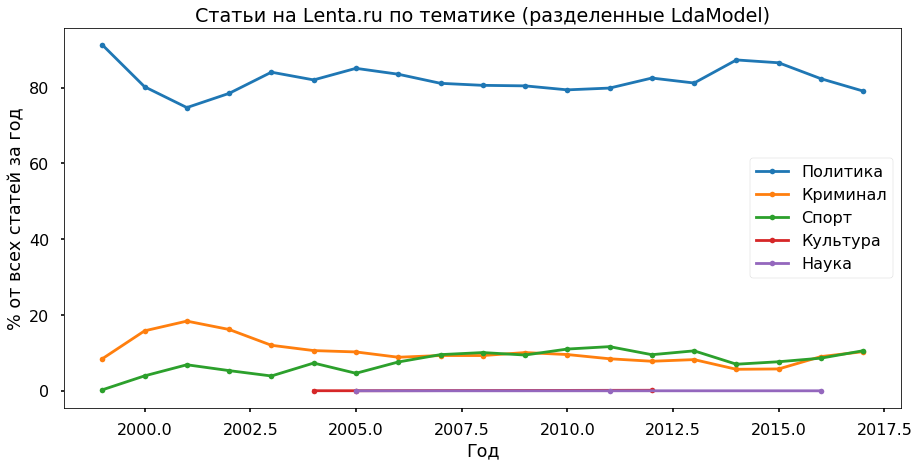

In [8]:
fig = plt.figure(figsize=[15, 7])
plt.title('Cтатьи на Lenta.ru по тематике (разделенные LdaModel)')
for i in topics.topics.unique():
    plt.plot(topics.years[topics.topics==i], topics.topics_by_years[topics.topics==i], label=i, marker='.')
plt.ylabel('% от всех статей за год')
plt.xlabel('Год')
plt.legend()
plt.show()
fig.savefig('../images/Cтатьи на Lenta по тематике.png')

In [2]:
# Распределение постов по субрубрикам
df_rubric = pd.DataFrame(columns=['df_subrubric', 'Year'])
for i in range(1999, 2018, 1):
    df_temp = pd.read_csv('../data/df_text_'+str(i)+'.csv', usecols=['df_subrubric'])
    df_temp['Year'] = i
    df_rubric = pd.concat([df_rubric, df_temp], ignore_index=True)

In [3]:
df_rubric = df_rubric.groupby('Year')['df_subrubric'].value_counts(normalize=True).reset_index(0)
df_rubric.index.name = 'names'
df_rubric = df_rubric.reset_index()

In [4]:
df_rubric.groupby('names')['df_subrubric'].mean().reset_index().\
sort_values('df_subrubric', ascending=False).head(20)

names  df_subrubric
74    Нет субрубрики      0.739714
81          Политика      0.110778
76          Общество      0.080934
111          Украина      0.063759
89      Происшествия      0.052376
29      Госэкономика      0.046926
116           Футбол      0.045085
50              Кино      0.030358
73             Наука      0.028068
98   Следствие и суд      0.027604
13            Бизнес      0.027350
42          Интернет      0.026027
90           Регионы      0.022679
86      Преступность      0.022500
63              Люди      0.020801
71            Музыка      0.018588
125          Явления      0.015162
70            Москва      0.014690
103            Стиль      0.012577
55          Криминал      0.012317

In [5]:
df_rubric = df_rubric[df_rubric.Year > 2012]

In [6]:
df_rubric.names[(df_rubric.names !='Политика')&
                (df_rubric.names !='Общество')&
                (df_rubric.names !='Украина')&
                (df_rubric.names !='Происшествия')&
                (df_rubric.names !='Футбол')] = 'Другое'

In [7]:
df_rubric.df_subrubric =  df_rubric.df_subrubric*100
df_rubric.groupby('names')['df_subrubric'].mean()

names
Другое           0.804702
Общество         9.711493
Политика        11.077843
Происшествия     5.237573
Украина          6.375920
Футбол           4.508520
Name: df_subrubric, dtype: float64

In [10]:
df_rubric.head()

names  Year  df_subrubric
35      Общество  2013     10.447062
36        Другое  2013     10.234519
37      Политика  2013      8.231565
38  Происшествия  2013      6.415937
39        Другое  2013      4.711985

In [11]:
df_rubric = df_rubric[df_rubric.names != 'Другое']

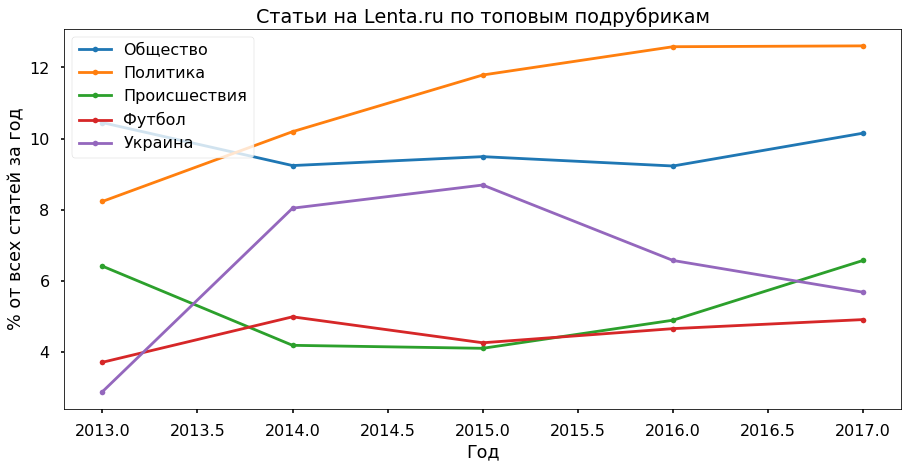

In [12]:
# График "Cтатьи на Lenta по топовым подрубрикам"
fig = plt.figure(figsize=[15, 7])
plt.title('Cтатьи на Lenta.ru по топовым подрубрикам')
for i in df_rubric.names.unique():
    plt.plot(df_rubric.Year[df_rubric.names==i], 
             df_rubric.df_subrubric[df_rubric.names==i], label=i, marker='.')
plt.ylabel('% от всех статей за год')
plt.xlabel('Год')
plt.legend()
plt.show()
fig.savefig('../images/Cтатьи на Lenta по топовым подрубрикам.png')

[К содержанию](#0)

<a id='Топ-10'></a>
### Топ-10

In [6]:
%%time
# Обучение моделей
documents = []
for i in range(1999, 2018, 1):
    # Загрузка данных
    globals()['df_text_%s' % i] = pd.read_csv('../data/df_text_'+str(i)+'.csv') 
    
    # Создание корпуса
    documents_temp = [[word for word in str(document).split()] for document in globals()['df_text_%s' % i].cleantext.tolist()]
    documents.extend(documents_temp)
    
    del globals()['df_text_%s' % i]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_all_10 = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                     num_topics=10,
                                     passes=30, alpha=1.25, eta=1.25)

CPU times: user 7h 10min 15s, sys: 4min 49s, total: 7h 15min 4s
Wall time: 2h 34min 34s


In [7]:
# Сохранение моделей
lda_all_10.save('../models/lda_all_10')

In [8]:
lda_all_10.print_topics(num_topics=10, num_words=20)

[(0,
  '0.000*"пэддок" + 0.000*"фельгенгауэр" + 0.000*"ирма" + 0.000*"трамп" + 0.000*"малороссия" + 0.000*"telegram" + 0.000*"сямозеро" + 0.000*"грица" + 0.000*"матильда" + 0.000*"гюлена" + 0.000*"рохинджа" + 0.000*"криптовалюта" + 0.000*"гнойный" + 0.000*"каталония" + 0.000*"рамбнуть" + 0.000*"mash" + 0.000*"brexit" + 0.000*"харви" + 0.000*"мособласть" + 0.000*"пучдемон"'),
 (1,
  '0.000*"пэддок" + 0.000*"фельгенгауэр" + 0.000*"ирма" + 0.000*"трамп" + 0.000*"малороссия" + 0.000*"telegram" + 0.000*"сямозеро" + 0.000*"грица" + 0.000*"матильда" + 0.000*"гюлена" + 0.000*"рохинджа" + 0.000*"криптовалюта" + 0.000*"гнойный" + 0.000*"каталония" + 0.000*"рамбнуть" + 0.000*"mash" + 0.000*"brexit" + 0.000*"харви" + 0.000*"мособласть" + 0.000*"пучдемон"'),
 (2,
  '0.002*"матч" + 0.002*"команда" + 0.001*"клуб" + 0.001*"спортсмен" + 0.001*"чемпионат" + 0.001*"олимпийский" + 0.001*"сборный" + 0.001*"победа" + 0.001*"игра" + 0.001*"счёт" + 0.001*"сезон" + 0.001*"спорт" + 0.001*"турнир" + 0.001*"лига"

[К содержанию](#0)

<a id='Предсказание популярности статьи'></a>
## Предсказание популярности статьи

<a id='XGBClassifier'></a>
### XGBClassifier

In [102]:
#  Загрузка данных за 2017
df_text_2017 = pd.read_csv('../data/df_text_2017.csv', 
                           usecols=['link', 'df_fb', 'df_subrubric', 'authors', 'cleantext'])

In [146]:
len(df_text_2017[df_text_2017.df_fb == 0])

3273

In [147]:
df_text_2017.head()

link  df_fb      df_subrubric  \
0   https://lenta.ru/news/2017/06/18/lenin_out/     88          Общество   
1  https://lenta.ru/news/2017/06/18/found_dead/     14  Вооруженные силы   
2     https://lenta.ru/news/2017/06/18/ziberov/      4      Преступность   
3       https://lenta.ru/news/2017/06/18/basta/      4           Украина   
4    https://lenta.ru/news/2017/06/18/petition/     45          Общество   

      authors                                          cleantext  
0  Нет автора  архиерей русский православный церковь рубеж рп...  
1  Нет автора  тело семь моряк американский эсминец uss fitzg...  
2  Нет автора  полиция округа монтгомери штат мэриленд сша ар...  
3  Нет автора  концерт одесса российский рэпер василий вакуле...  
4  Нет автора  200 тысяча человек подписать петиция направить...

In [103]:
# Разделение на популярные и наименее популярные
df_text_2017 = df_text_2017.sort_values('df_fb', ascending=False)
df_text_2017['popular'] = 'uknown'
df_text_2017.popular[0:3273] = 'high'
df_text_2017 = df_text_2017.sort_values('df_fb')
df_text_2017.popular[0:3273] = 'low'
df_text_2017 = df_text_2017[df_text_2017.popular != 'uknown']
df_text_2017.popular = df_text_2017.popular.astype('category')
df_text_2017.popular = df_text_2017.popular.cat.codes

In [104]:
# Разделение на тренировочную и тестовую выборку
train, test = train_test_split(df_text_2017, test_size = 0.3, random_state=123)

In [105]:
train.popular.value_counts()

0    2297
1    2285
Name: popular, dtype: int64

In [106]:
test.popular.value_counts()

1    988
0    976
Name: popular, dtype: int64

In [158]:
# Обучение XGBClassifier
pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier(random_state=123))])
# Параметры для перебора по сетке
parameters_grid = {
    'clf__learning_rate': [0.3, 0.5, 0.8],
    'clf__n_estimators': [200],
    'clf__max_depth': [3, 5, 8],
    'clf__n_jobs': [6],
    
} 

In [159]:
%%time
# Стратегия кроссвалидации
clf = GridSearchCV(pipe, cv=3, 
                   param_grid=parameters_grid, 
                   scoring='f1').fit(train.cleantext, train.popular.tolist())

CPU times: user 1h 7min 56s, sys: 30.4 s, total: 1h 8min 27s
Wall time: 12min 54s


In [160]:
# f1_score модели на валидации 
clf.best_score_

0.7523974365355197

In [161]:
# Сохранение модели
pickle.dump(clf, open('../models/model_XGBClassifier.pkl', 'wb' ))

In [21]:
# Загрузка модели
clf = pickle.load(open('../models/model_XGBClassifier.pkl', 'rb' ))

In [162]:
# Предсказание
y_predict = clf.predict(test.cleantext)

In [163]:
clf.best_estimator_.steps[2][1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=6, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [164]:
# f1_score модели на трейне
f1_score(clf.predict(train.cleantext), train.popular, average='weighted')

0.9718466945749398

In [165]:
# f1_score модели на тесте
f1_score(y_predict, test.popular, average='weighted')

0.7648048243835586

In [166]:
# acc модели на тесте
accuracy_score(y_predict, test.popular)

0.7647657841140529

In [167]:
print(classification_report(y_predict, test.popular))

             precision    recall  f1-score   support

          0       0.75      0.77      0.76       956
          1       0.78      0.76      0.77      1008

avg / total       0.77      0.76      0.76      1964



In [168]:
print(confusion_matrix(y_predict, test.popular))

[[735 221]
 [241 767]]


[К содержанию](#0)

<a id='LogisticRegression'></a>
### LogisticRegression

In [209]:
# Обучение XGBClassifier
pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])
# Параметры для перебора по сетке
parameters_grid = {
    'clf__random_state': [1234],
    'clf__class_weight': ['balanced'],
    'clf__n_jobs': [6],   
} 

In [210]:
%%time
# Стратегия кроссвалидации
clf = GridSearchCV(pipe, cv=3, 
                   param_grid=parameters_grid, 
                   scoring='f1').fit(train.cleantext, train.popular.tolist())

CPU times: user 27.9 s, sys: 192 ms, total: 28.1 s
Wall time: 17.4 s


In [211]:
# f1_score модели на валидации 
clf.best_score_

0.7798102986839861

In [212]:
# Сохранение модели
pickle.dump(clf, open('../models/model_LogisticRegression.pkl', 'wb' ))

In [ ]:
# Загрузка модели
clf = pickle.load(open('../models/model_LogisticRegression.pkl', 'rb' ))

In [213]:
# Предсказание
y_predict = clf.predict(test.cleantext)

In [214]:
clf.best_estimator_.steps[2][1]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=6, penalty='l2', random_state=1234,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [216]:
# f1_score модели на тесте
f1_score(y_predict, test.popular, average='weighted')

0.8063367824038786

In [215]:
# f1_score модели на трейне
f1_score(clf.predict(train.cleantext), train.popular, average='weighted')

0.9587532185167044

In [217]:
# acc модели на тесте
accuracy_score(y_predict, test.popular)

0.8060081466395111

In [218]:
print(classification_report(y_predict, test.popular))

             precision    recall  f1-score   support

          0       0.85      0.78      0.81      1063
          1       0.76      0.84      0.80       901

avg / total       0.81      0.81      0.81      1964



In [219]:
print(confusion_matrix(y_predict, test.popular))

[[829 234]
 [147 754]]


[К содержанию](#0)

<a id='Embedding & LSTM'></a>
### Embedding & LSTM

In [169]:
# Кодирование слов
vocab_size = 2000
X_train = [one_hot(d, vocab_size) for d in train.cleantext.tolist()]
X_test = [one_hot(d, vocab_size) for d in test.cleantext.tolist()]

In [170]:
# Приведение статей к единой длине
max_review_length = 200 
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length) 
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [171]:
# В numpy array
y_train = np.array(train.popular.tolist())
y_test = np.array(test.popular.tolist())

In [228]:
# Построение модели
top_words = 3000
embedding_vector_length = 100 
model = Sequential() 
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
model.add(LSTM(100)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          300000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 380,501
Trainable params: 380,501
Non-trainable params: 0
_________________________________________________________________
None


In [229]:
%%time
# Обучение модели
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('../models/model_LSTM.h5', verbose=1, save_best_only=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=60,
          callbacks=[earlystopper, checkpointer])

Train on 3665 samples, validate on 917 samples
Epoch 1/300
3665/3665 [==============================] - 14s 4ms/step - loss: 0.6564 - acc: 0.5902 - val_loss: 0.5667 - val_acc: 0.7165

Epoch 00001: val_loss improved from inf to 0.56674, saving model to ../models/model_LSTM.h5
Epoch 2/300
3665/3665 [==============================] - 13s 4ms/step - loss: 0.4947 - acc: 0.7738 - val_loss: 0.5862 - val_acc: 0.6990

Epoch 00002: val_loss did not improve from 0.56674
Epoch 3/300
3665/3665 [==============================] - 13s 3ms/step - loss: 0.4175 - acc: 0.8207 - val_loss: 0.6046 - val_acc: 0.6881

Epoch 00003: val_loss did not improve from 0.56674
Epoch 4/300
3665/3665 [==============================] - 13s 3ms/step - loss: 0.3461 - acc: 0.8688 - val_loss: 0.6929 - val_acc: 0.7023

Epoch 00004: val_loss did not improve from 0.56674
Epoch 5/300
3665/3665 [==============================] - 13s 3ms/step - loss: 0.2723 - acc: 0.8958 - val_loss: 0.7474 - val_acc: 0.7132

Epoch 00005: val_loss d

In [230]:
# Точность на тесте
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.42%


In [231]:
# Предсказание
y_predict = model.predict_classes(X_test)

In [232]:
# f1_score модели на тесте
f1_score(y_predict, y_test, average='weighted')

0.7045169932598757

In [233]:
# f1_score модели на трейне
f1_score(model.predict_classes(X_train), y_train, average='weighted')

0.9255889472871335

In [234]:
print(classification_report(y_predict, test.popular))

             precision    recall  f1-score   support

          0       0.74      0.69      0.71      1049
          1       0.67      0.72      0.69       915

avg / total       0.71      0.70      0.70      1964



In [235]:
print(confusion_matrix(y_predict, test.popular))

[[722 327]
 [254 661]]


[К содержанию](#0)

<a id='Тематика популярных/непопулярных статей'></a>
## Тематика популярных/непопулярных статей

In [18]:
#  Загрузка данных за 2017
df_text_2017 = pd.read_csv('../data/df_text_2017.csv', 
                           usecols=['link', 'df_fb', 'df_subrubric', 'authors', 'cleantext'])

# Разделение на популярные и наименее популярные
df_text_2017 = df_text_2017.sort_values('df_fb', ascending=False)
df_text_2017['popular'] = 'uknown'
df_text_2017.popular[0:3273] = 'high'
df_text_2017 = df_text_2017.sort_values('df_fb')
df_text_2017.popular[0:3273] = 'low'
df_text_2017 = df_text_2017[df_text_2017.popular != 'uknown']
df_text_2017.popular = df_text_2017.popular.astype('category')

In [19]:
df_text_2017 = df_text_2017.sort_values('df_fb')

In [20]:
df_text_2017.head()

link  df_fb  \
7834             https://lenta.ru/news/2017/07/26/share/      0   
19534        https://lenta.ru/news/2017/09/25/millioner/      0   
19538  https://lenta.ru/news/2017/10/05/japan_cosmetics/      0   
1222            https://lenta.ru/news/2017/06/23/jackie/      0   
12692  https://lenta.ru/news/2017/08/25/rekultivatsiy...      0   

           df_subrubric     authors  \
7834   Вооруженные силы  Нет автора   
19534           Явления  Нет автора   
19538       Внешний вид  Нет автора   
1222               Часы  Нет автора   
12692           Регионы  Нет автора   

                                               cleantext popular  
7834   уровень оснащение вооружённый сила россия совр...     low  
19534  итальянский предприниматель джанлука вакки изв...     low  
19538  московский модный универмаг цум открыться корн...     low  
1222   новый владелица часы который принадлежать бывш...     low  
12692  работа рекультивация мусорный полигон твёрдый ...     low

In [21]:
df_text_2017.tail()

link  df_fb  df_subrubric  \
11166        https://lenta.ru/news/2017/08/16/glagoleva/    688          Кино   
23443  https://lenta.ru/articles/2017/10/31/mutiny_1916/    769  Средняя Азия   
20157       https://lenta.ru/articles/2017/10/12/doktor/   1042      Общество   
4352            https://lenta.ru/news/2017/06/30/device/   1128   Инструменты   
21838  https://lenta.ru/articles/2017/10/21/bolshevik...   1354      Общество   

                         authors  \
11166                 Нет автора   
23443         Роберт Берновский    
20157  Записала Наталья Гранина    
4352                  Нет автора   
21838      Записал Михаил Карпов   

                                               cleantext popular  
11166  российский актриса вера глаголев скончаться сш...    high  
23443  26 октябрь президент киргизия алмазбек атамбае...    high  
20157  недавний телеинтервью министр здравоохранение ...    high  
4352   июль 2017 год россия стартовать продажа новый ...    high  
21838  советский власть самый начало пытаться создать...    high

In [173]:
%%time
# Обучение моделей
df_text_2017_low = df_text_2017[df_text_2017.popular == 'low'] 
# Создание корпуса
documents = [[word for word in str(document).split()] for document in df_text_2017_low.cleantext.tolist()]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_all_1_low = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                     num_topics=2,
                                     passes=30, alpha=1.25, eta=1.25)

CPU times: user 4min, sys: 2.5 s, total: 4min 2s
Wall time: 1min 33s


In [174]:
lda_all_1_low.print_topics(num_topics=2, num_words=20)

[(0,
  '0.001*"россия" + 0.001*"процент" + 0.001*"рубль" + 0.001*"год" + 0.000*"область" + 0.000*"тысяча" + 0.000*"человек" + 0.000*"июль" + 0.000*"российский" + 0.000*"август" + 0.000*"президент" + 0.000*"который" + 0.000*"регион" + 0.000*"город" + 0.000*"весь" + 0.000*"компания" + 0.000*"глава" + 0.000*"сентябрь" + 0.000*"июнь" + 0.000*"также"'),
 (1,
  '0.000*"коллекция" + 0.000*"бренд" + 0.000*"марка" + 0.000*"модель" + 0.000*"одежда" + 0.000*"представить" + 0.000*"часы" + 0.000*"магазин" + 0.000*"основать" + 0.000*"аксессуар" + 0.000*"обувь" + 0.000*"модный" + 0.000*"линейка" + 0.000*"дизайнер" + 0.000*"выпустить" + 0.000*"кожа" + 0.000*"мужской" + 0.000*"компания" + 0.000*"редакция" + 0.000*"дом"')]

In [176]:
%%time
# Обучение моделей
df_text_2017_high = df_text_2017[df_text_2017.popular == 'high'] 
# Создание корпуса
documents = [[word for word in str(document).split()] for document in df_text_2017_high.cleantext.tolist()]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_all_1_high = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, 
                                     num_topics=2,
                                     passes=30, alpha=1.25, eta=1.25)

CPU times: user 6min 15s, sys: 3.73 s, total: 6min 18s
Wall time: 2min 15s


In [177]:
lda_all_1_high.print_topics(num_topics=2, num_words=20)

[(0,
  '0.000*"to" + 0.000*"a" + 0.000*"and" + 0.000*"i" + 0.000*"in" + 0.000*"by" + 0.000*"on" + 0.000*"галерея" + 0.000*"анжелика" + 0.000*"фотограф" + 0.000*"at" + 0.000*"you" + 0.000*"pdt" + 0.000*"shared" + 0.000*"the" + 0.000*"of" + 0.000*"be" + 0.000*"видео" + 0.000*"my" + 0.000*"ролик"'),
 (1,
  '0.000*"украина" + 0.000*"россия" + 0.000*"весь" + 0.000*"человек" + 0.000*"год" + 0.000*"президент" + 0.000*"сша" + 0.000*"страна" + 0.000*"процент" + 0.000*"российский" + 0.000*"свой" + 0.000*"мочь" + 0.000*"который" + 0.000*"тысяча" + 0.000*"время" + 0.000*"сентябрь" + 0.000*"женщина" + 0.000*"заявить" + 0.000*"москва" + 0.000*"рубль"')]

In [22]:
# Распределение популярных и непопулярных статей по субрубрикам
rubric_2017_low = df_text_2017[df_text_2017.popular == 'low'].df_subrubric.value_counts()
rubric_2017_low = pd.DataFrame(rubric_2017_low)
rubric_2017_high = df_text_2017[df_text_2017.popular == 'high'].df_subrubric.value_counts()
rubric_2017_high = pd.DataFrame(rubric_2017_high)
rubric_2017 = pd.merge(rubric_2017_low, rubric_2017_high, 
                       left_on=rubric_2017_low.index, 
                       right_on=rubric_2017_high.index, how='inner')
rubric_2017 = rubric_2017.sort_values('df_subrubric_y', ascending=False)
rubric_2017_x = rubric_2017.sort_values('df_subrubric_x', ascending=False)

In [26]:
# Сравнение распределений с помощью статистического теста
# Распределения значимо отличаются
chisquare(rubric_2017.df_subrubric_x, rubric_2017.df_subrubric_y)

Power_divergenceResult(statistic=14284.335874190583, pvalue=0.0)

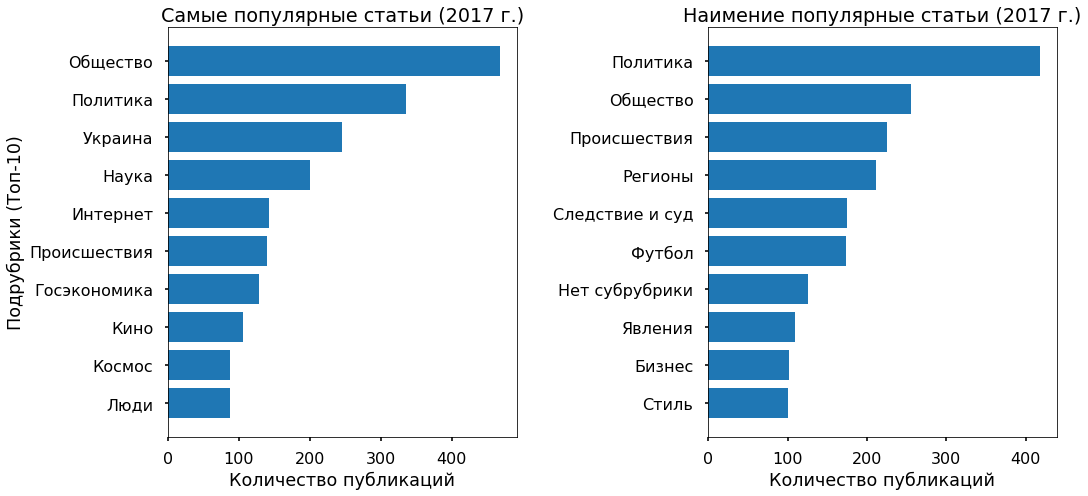

In [29]:
# График "Тематика популярных статей"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(121)
ax.barh(np.arange(len(rubric_2017.key_0))[::-1][0:10], rubric_2017.df_subrubric_y[0:10])
ax.set_yticks(np.arange(len(rubric_2017.key_0))[::-1][0:10])
ax.set_yticklabels(rubric_2017.key_0[0:10])
plt.title('Самые популярные статьи (2017 г.)')
plt.ylabel('Подрубрики (Топ-10)')
plt.xlabel('Количество публикаций')

ax = fig.add_subplot(122)
ax.barh(np.arange(len(rubric_2017_x.key_0))[::-1][0:10], rubric_2017_x.df_subrubric_x[0:10])
ax.set_yticks(np.arange(len(rubric_2017_x.key_0))[::-1][0:10])
ax.set_yticklabels(rubric_2017_x.key_0[0:10])
plt.title('Наимение популярные статьи (2017 г.)')
plt.ylabel(' ')
plt.xlabel('Количество публикаций')

plt.tight_layout()
plt.show()
fig.savefig('../images/Тематика популярных статей.png')

[К содержанию](#0)

<a id='Самые популярные авторы'></a>
## Самые популярные авторы

In [30]:
# Распределение постов по субрубрикам
df_authors = pd.DataFrame(columns=['authors', 'df_fb', 'Year'])
for i in range(1999, 2018, 1):
    df_temp = pd.read_csv('../data/df_text_'+str(i)+'.csv', usecols=['authors', 'df_fb'])
    df_temp['Year'] = i
    df_authors = pd.concat([df_authors, df_temp], ignore_index=True)
df_authors[['df_fb', 'Year']] = df_authors[['df_fb', 'Year']].astype('int')

In [32]:
# 98% статей не имеют автора
df_authors.authors.value_counts(normalize=True).head(5)

Нет автора         0.975605
Михаил Тищенко     0.000503
Андрей Кузнецов    0.000485
Татьяна Меликян    0.000474
Александр Амзин    0.000453
Name: authors, dtype: float64

In [292]:
# Авторы по сумме репостов
df_authors.groupby('authors')['df_fb'].sum().reset_index().sort_values('df_fb', ascending=False).head(10)

authors    df_fb
879                  Нет автора  1095734
865            Наталья Гранина      3390
133              Андрей Борисов     3176
615       Записал Михаил Карпов     2945
233   Беседовал Андрей Мозжухин     2886
459            Владимир Тодоров     2728
38            Александр Еникеев     2726
80            Алексей Куприянов     2721
671              Игорь Кармазин     2115
1044            Татьяна Меликян     2070

In [33]:
# Очистка графы "Автор"
df_authors.authors = df_authors.authors.str.replace('^Записал ', '')
df_authors.authors = df_authors.authors.str.replace('^Записал. ', '')
df_authors.authors = df_authors.authors.str.replace('^Беседовал ', '')
df_authors.authors = df_authors.authors.str.replace('^Беседовал. ', '')
df_authors.authors = df_authors.authors.str.replace('^Подготовил ', '')
df_authors.authors = df_authors.authors.str.replace('^Подготовил. ', '')

In [35]:
# Авторы по сумме репостов после очистки
df_authors = df_authors.groupby('authors')['df_fb'].sum().reset_index().sort_values('df_fb', ascending=False)
df_authors['percent'] = df_authors.df_fb/df_authors.df_fb.sum()*100
df_authors.head(20)

authors    df_fb    percent
713           Нет автора  1095734  88.096383
696     Наталья Гранина      6674   0.536586
164      Андрей Мозжухин     4943   0.397414
658        Михаил Карпов     4424   0.355687
145       Андрей Борисов     3255   0.261700
702    Наталья Кочеткова     2937   0.236133
289     Владимир Тодоров     2772   0.222867
86     Алексей Куприянов     2772   0.222867
139  Анастасия Чеповская     2769   0.222626
41     Александр Еникеев     2738   0.220134
482       Игорь Кармазин     2635   0.211852
893           Юлия Верби     2164   0.173984
389      Дмитрий Мигунов     2142   0.172216
822         Сергей Лютых     2139   0.171974
864      Татьяна Меликян     2070   0.166427
103       Алексей Сочнев     1985   0.159593
225     Артем Космарский     1983   0.159432
615       Марат Селезнев     1930   0.155171
45      Александр Зайцев     1915   0.153965
321       Григорий Коган     1766   0.141985

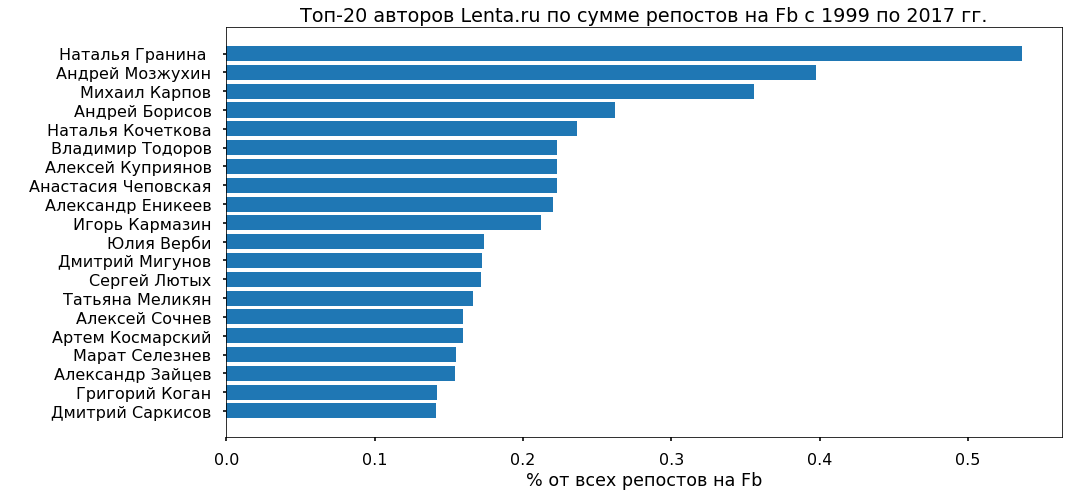

In [36]:
# График "Популярные авторы"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_authors[df_authors.authors != 'Нет автора'].authors))[::-1][0:20], 
        df_authors[df_authors.authors != 'Нет автора'].percent[0:20])
ax.set_yticks(np.arange(len(df_authors[df_authors.authors != 'Нет автора'].authors))[::-1][0:20])
ax.set_yticklabels(df_authors[df_authors.authors != 'Нет автора'].authors[0:20])
plt.title('Топ-20 авторов Lenta.ru по сумме репостов на Fb c 1999 по 2017 гг.')
plt.ylabel(' ')
plt.xlabel('% от всех репостов на Fb')

plt.tight_layout()
plt.show()
fig.savefig('../images/Популярные авторы.png')

In [278]:
# Тексты 2017 года
df_authors_2017 = pd.read_csv('../data/df_text_'+'2017'+'.csv', usecols=['authors', 'df_fb'])

In [281]:
df_authors_2017.groupby('authors')['df_fb'].sum().reset_index().sort_values('df_fb', ascending=False).head(10)

authors   df_fb
230                 Нет автора  197947
46              Андрей Борисов    1715
169      Записал Михаил Карпов    1626
70   Беседовал Андрей Мозжухин    1357
28              Алексей Наумов    1252
228           Наталья Гранина     1042
174  Записала Наталья Гранина     1042
269         Роберт Берновский      997
238             Олег Парамонов     994
222              Михаил Карпов     852

In [282]:
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Записал ', '')
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Записал. ', '')
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Беседовал ', '')
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Беседовал. ', '')
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Подготовил ', '')
df_authors_2017.authors = df_authors_2017.authors.str.replace('^Подготовил. ', '')

In [283]:
df_authors_2017.groupby('authors')['df_fb'].median().reset_index().sort_values('df_fb', ascending=False).head(20)

authors  df_fb
58                               Анна Никитина   161.0
132                              Игорь Игрицкий  153.0
141                Игорь Надеждин|Мария Фролова  148.0
153                              Кирилл Комаров  145.5
76              Виктор Вилисов| Илья Кролевский  124.0
205         Покушать принесла Алёна Кожевникова  118.0
126                        Елизавета Деньчикова  116.0
129                Иван Петров|Алексей Стейнерт  106.0
216               Сергей Лютых|Александр Зайцев  105.0
152                                   Ирина Мак  102.0
77                          Виктория Решульская  101.0
201                                 Ольга Гердт  100.0
50                              Андрей Мозжухин   98.5
19                          Александр Свистунов   96.0
84                 Владимир Добрынин (Аликанте)   91.0
189       Наталья Кочеткова|Николай Александров   88.0
27                                Алексей Исаев   80.0
17                           Александр Ломанов    70.0
85                               Владимир Зотов   69.0
150  Илья Кролевский (Москва — Санкт-Петербург)   69.0

In [284]:
df_authors_2017 = df_authors_2017.groupby('authors')['df_fb'].sum().reset_index().sort_values('df_fb', 
                                                                                              ascending=False)
df_authors_2017['percent'] = df_authors_2017.df_fb/df_authors_2017.df_fb.sum()*100

In [285]:
df_authors_2017.head(20)

authors   df_fb    percent
190             Нет автора  197947  84.051073
180          Михаил Карпов    2627   1.115461
187       Наталья Гранина     2435   1.033935
48          Андрей Борисов    1723   0.731610
50         Андрей Мозжухин    1535   0.651783
29          Алексей Наумов    1265   0.537137
198         Олег Парамонов    1120   0.475568
210     Роберт Берновский      997   0.423340
188      Наталья Кочеткова     889   0.377482
104        Дмитрий Мигунов     764   0.324405
16        Александр Зайцев     735   0.312091
14       Александр Еникеев     725   0.307845
215           Сергей Лютых     702   0.298079
135         Игорь Кармазин     668   0.283642
110        Дмитрий Сидоров     666   0.282793
168         Марат Селезнев     646   0.274301
57           Анна Никитина     593   0.251796
166         Любовь Ширижик     578   0.245427
83   Владимир Веретенников     549   0.233113
136         Игорь Надеждин     534   0.226744

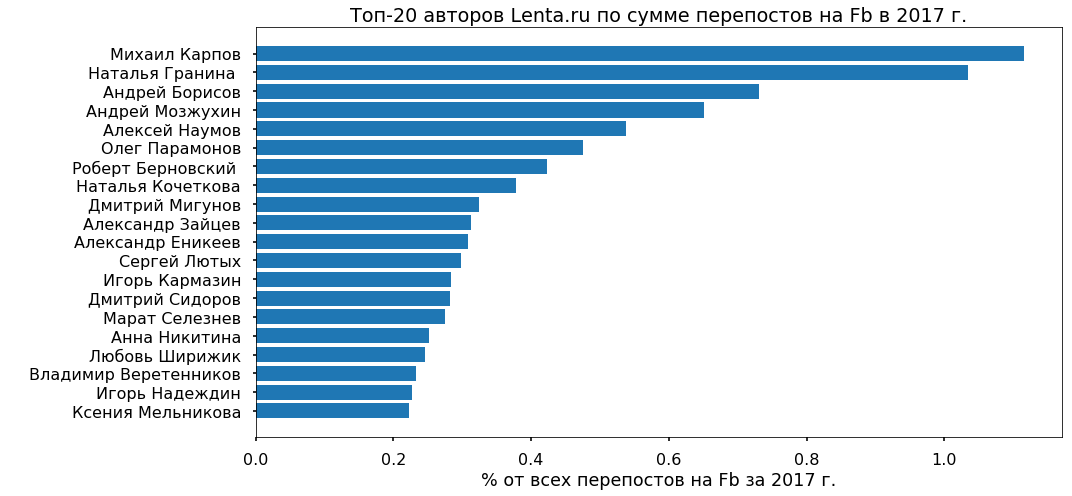

In [286]:
# График "Популярные авторы 2017"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_authors_2017[df_authors_2017.authors != 'Нет автора'].authors))[::-1][0:20], 
        df_authors_2017[df_authors_2017.authors != 'Нет автора'].percent[0:20])
ax.set_yticks(np.arange(len(df_authors_2017[df_authors_2017.authors != 'Нет автора'].authors))[::-1][0:20])
ax.set_yticklabels(df_authors_2017[df_authors_2017.authors != 'Нет автора'].authors[0:20])
plt.title('Топ-20 авторов Lenta.ru по сумме перепостов на Fb в 2017 г.')
plt.ylabel(' ')
plt.xlabel('% от всех перепостов на Fb за 2017 г.')

plt.tight_layout()
plt.show()
fig.savefig('../images/Популярные авторы 2017.png')

[К содержанию](#0)

<a id='Путин и Украина в контексте'></a>
## Путин и Украина в контексте

### Путин

In [285]:
#  Загрузка данных за 2000
df_text_2000 = pd.read_csv('../data/df_text_2000.csv', usecols=['cleantext'])

In [286]:
docs_putin_2000 = [[word for word in str(document).split()] for document in df_text_2000.cleantext.tolist() 
                   if 'путин' in document]

In [287]:
# Обучение модели
model = Word2Vec(docs_putin_2000, min_count=1)
X = model[model.wv.vocab]

In [288]:
len(X)

9471

In [289]:
# Двумерное пространство
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

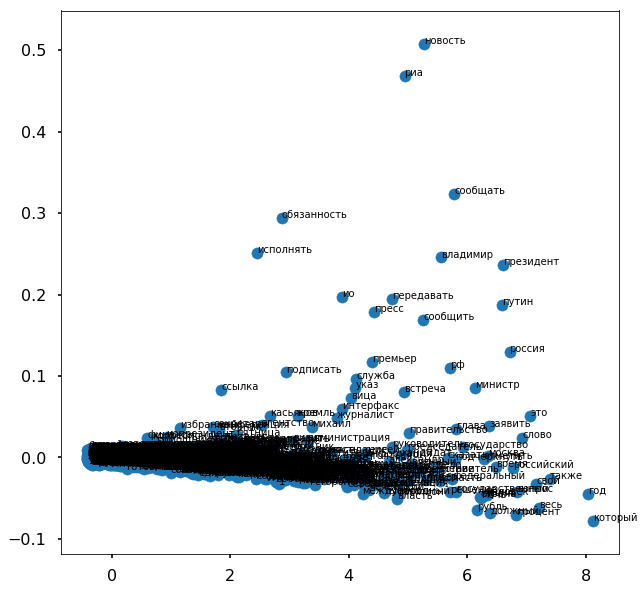

In [290]:
# Путин_2000
fig = plt.figure(figsize=[10,10])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()
fig.savefig('../images/Путин_2000.png')

In [291]:
#  Загрузка данных за 2017
df_text_2017 = pd.read_csv('../data/df_text_2017.csv', usecols=['cleantext'])

In [292]:
docs_putin_2017 = [[word for word in str(document).split()] for document in df_text_2017.cleantext.tolist() 
                   if 'путин' in document]

In [293]:
# Обучение модели
model = Word2Vec(docs_putin_2017, min_count=1)
X = model[model.wv.vocab]

In [294]:
len(X)

24140

In [295]:
# Двумерное пространство
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

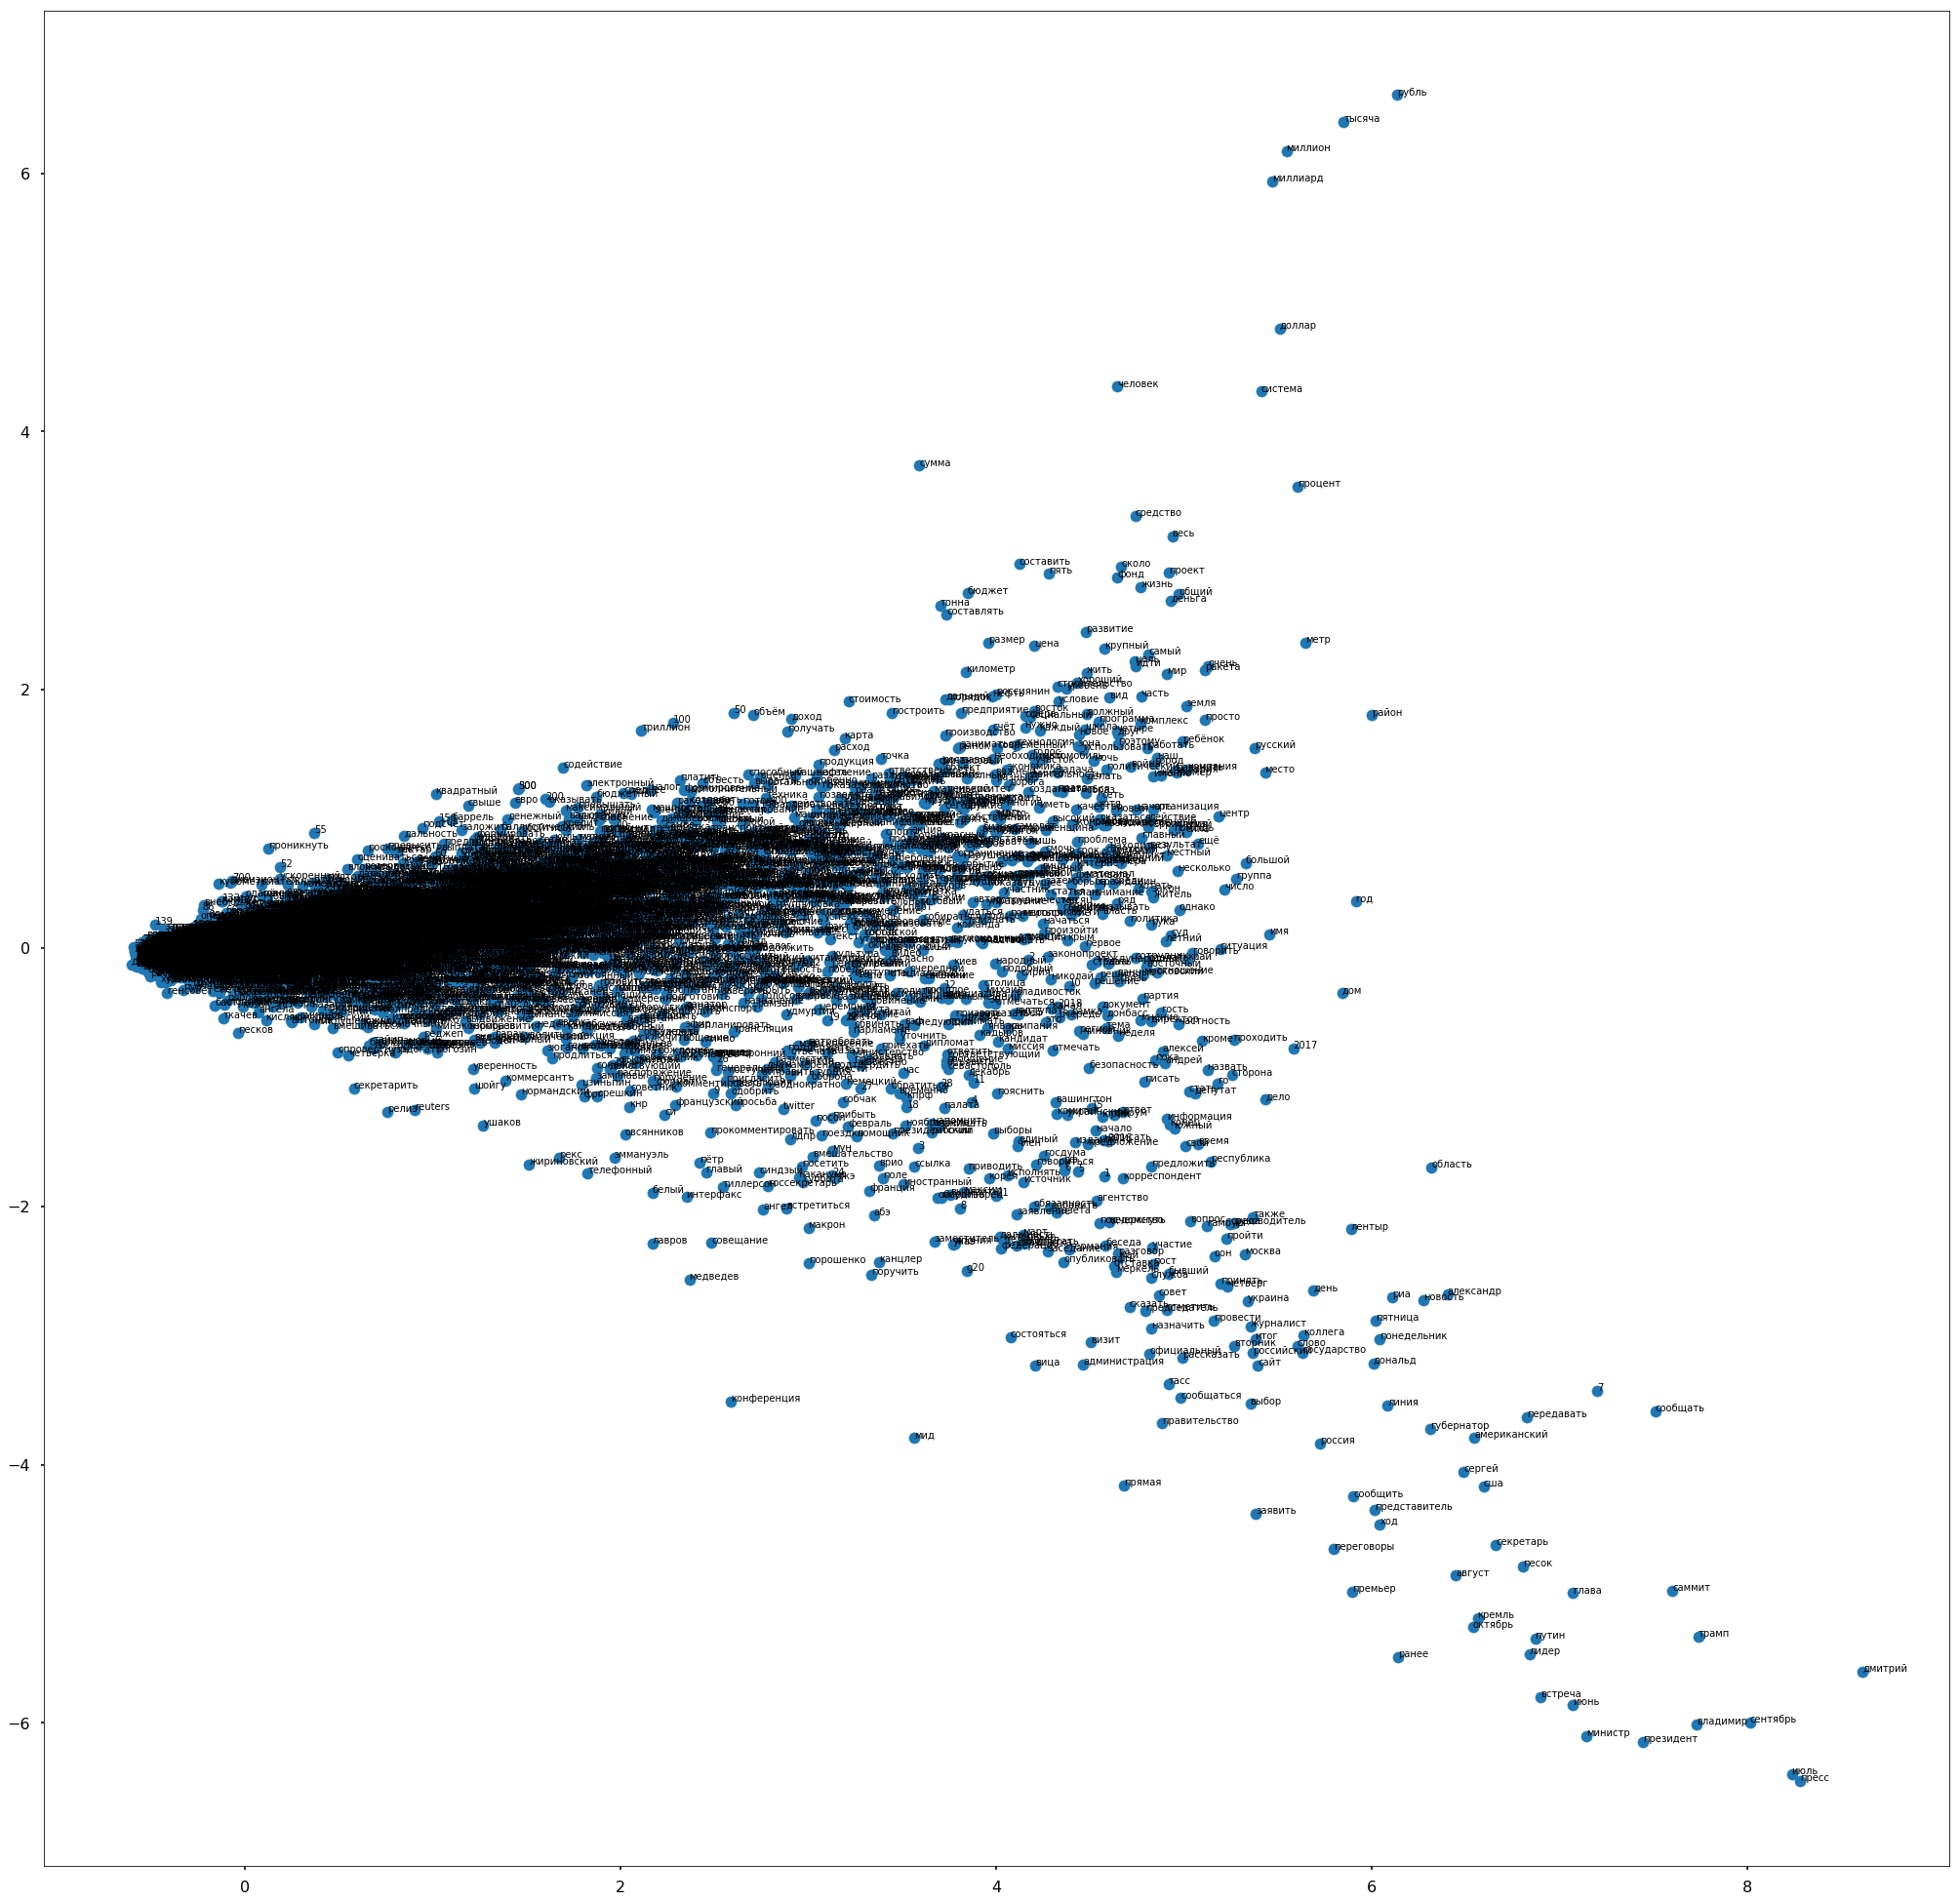

In [296]:
# Путин_2017
fig = plt.figure(figsize=[35,35])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()
fig.savefig('../images/Путин_2017.png')

### Украина

In [262]:
# Загрузка данных за 2015
df_text_2015 = pd.read_csv('../data/df_text_2015.csv') 

In [263]:
docs_ukr_2015 = [[word for word in str(document).split()] for document in df_text_2015.cleantext.tolist() 
                 if 'украина' in document]

In [264]:
len(docs_ukr_2015)

2920

In [265]:
model = Word2Vec(docs_ukr_2015, min_count=1)
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

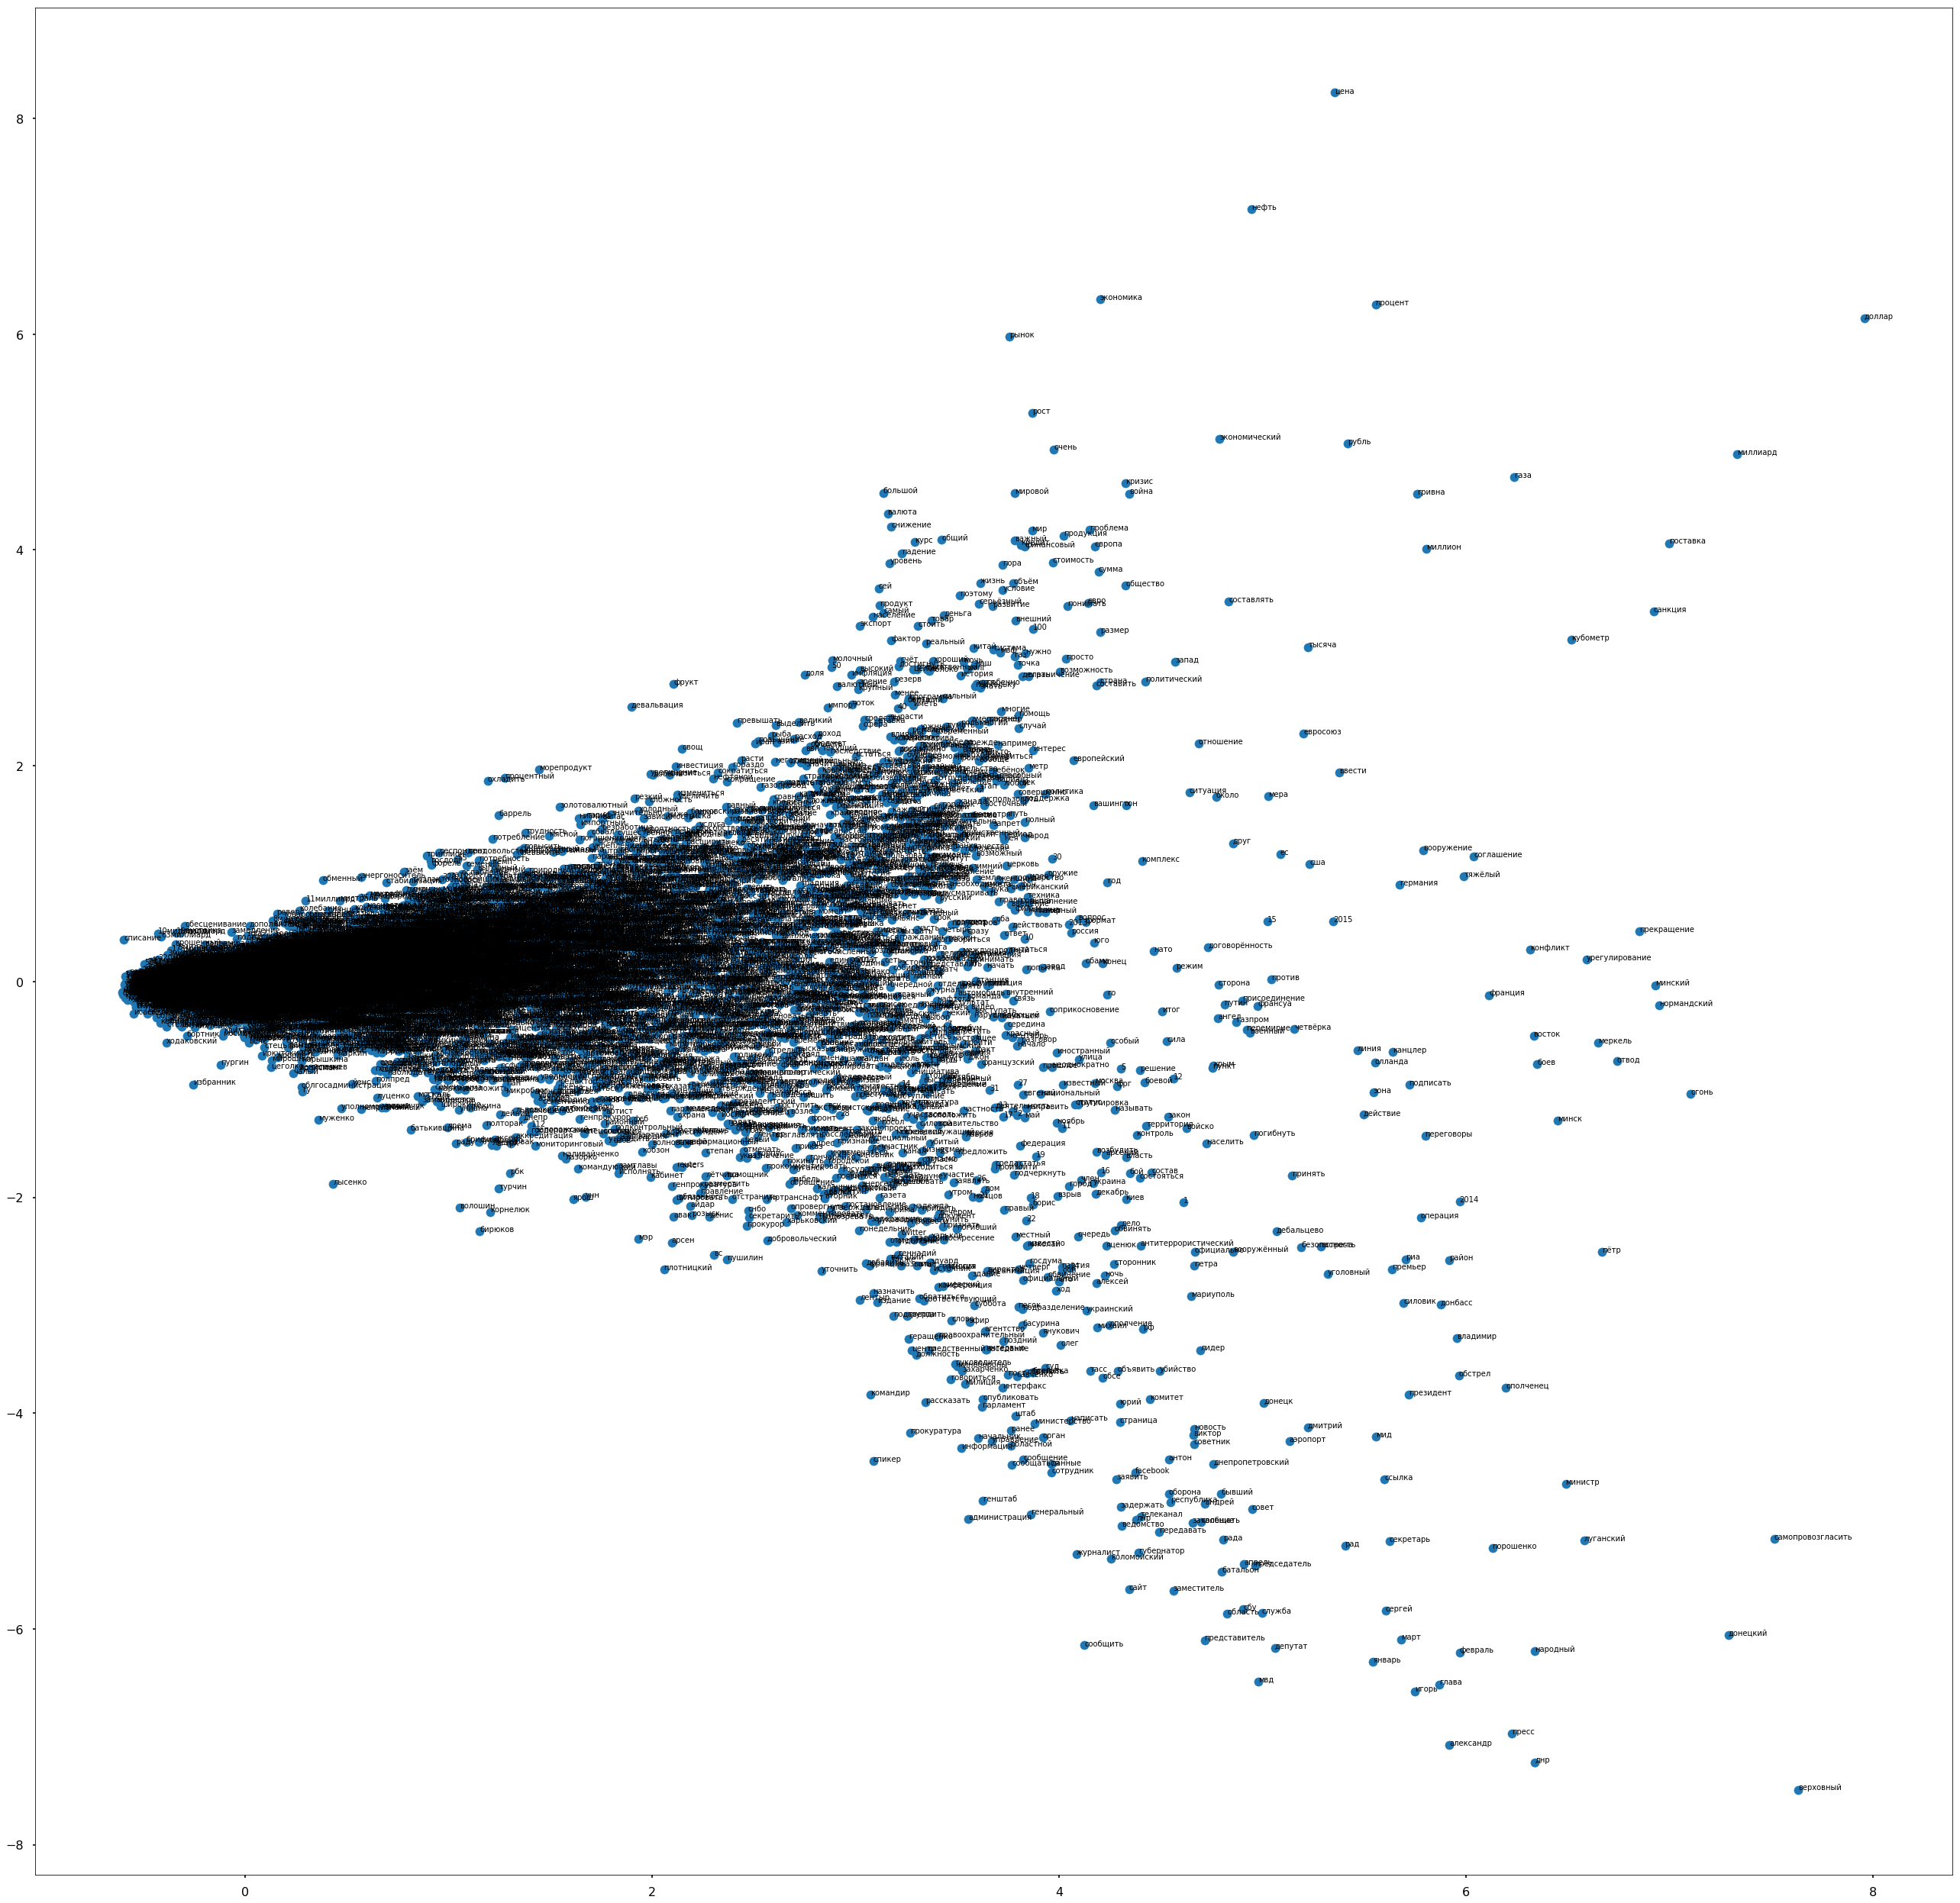

In [266]:
# Украина 2015
fig = plt.figure(figsize=[45,45])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()
fig.savefig('../images/Украина_2015.png')

In [297]:
# Загрузка данных за 2017
df_text_2017 = pd.read_csv('../data/df_text_2017.csv') 

In [298]:
docs_ukr_2017 = [[word for word in str(document).split()] for document in df_text_2017.cleantext.tolist() 
                 if 'украина' in document]

In [299]:
len(docs_ukr_2017)

2429

In [317]:
model = Word2Vec(docs_ukr_2017, min_count=1)
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

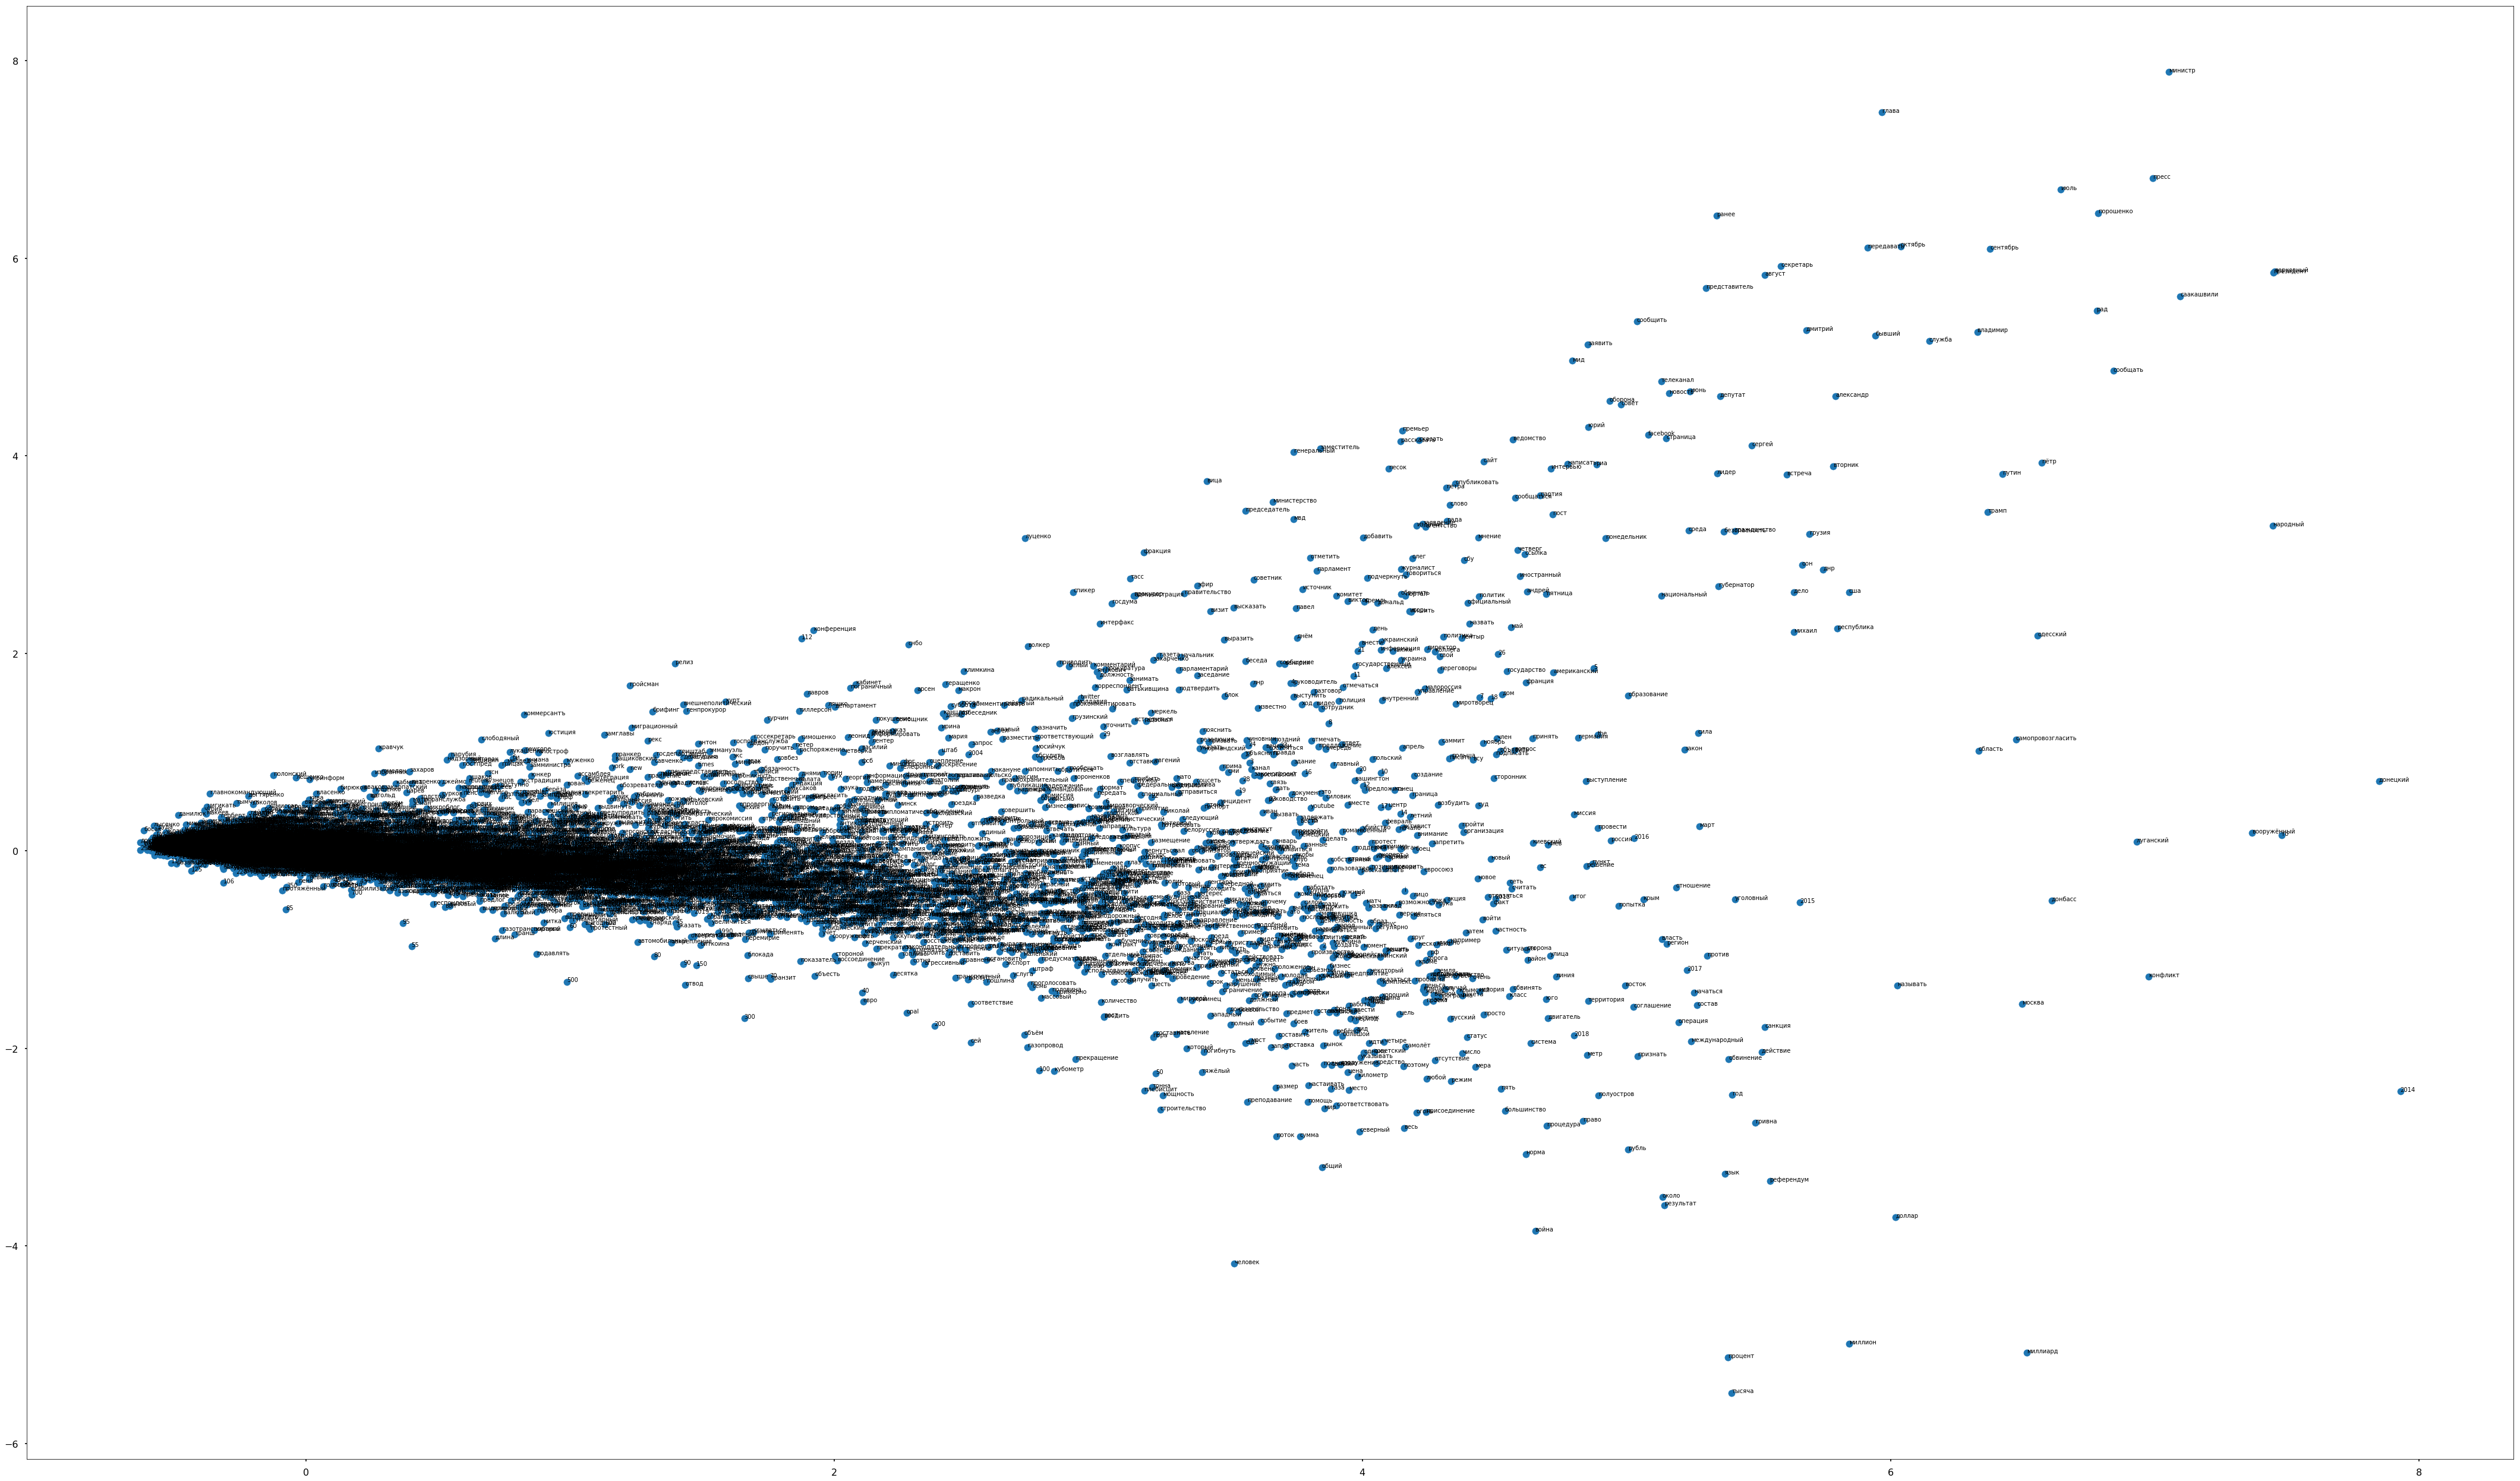

In [319]:
# Украина 2017
fig = plt.figure(figsize=[75,45])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()
fig.savefig('../images/Украина_2017.png')

[К содержанию](#0)